<a href="https://colab.research.google.com/github/pragmalingu/experiments/blob/master/02_Embeddings/Experiment/Second_Experiment_BERT_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second Experiment



For our second experiment we connect the Notebook to an Elasticsearch instance and compare a standard Elasticsearch operator with Embeddings we get from BERT (Bi-Directional Encoder Representation from Transformer). The Embeddings are indexed built-in stemming methods: 'Stemmer Token Filter' and 'Hunspell Token Filter'. 
(To read details about this experiment visit our [website](https://pragmalingu.de/docs/experiments/experiment1))

## Setup an Elasticsearch Instance in Google Colab

Everthing to connect to Elasticsearch, for detailed explaination see [this Notebook.](https://)
Download:

In [1]:
import os
from subprocess import Popen, PIPE, STDOUT
# download elasticsearch
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.1-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.9.1-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.9.1


Start a local server:

In [2]:
# start server
es_server = Popen(['elasticsearch-7.9.1/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
# client-side
!pip install elasticsearch -q
from elasticsearch import Elasticsearch
from datetime import datetime
es = Elasticsearch(["localhost:9200/"])
#wait a bit
import time
time.sleep(30)
es.ping()  # got True

     |████████████████████████████████| 327kB 5.3MB/s 


True

In [3]:
#print new index list
create_response = es.cat.indices()
print(create_response)

## Download and intializie pretrained BERT model

In [4]:
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
import torch
from tqdm import tqdm_notebook

model = SentenceTransformer('bert-base-nli-mean-tokens')

# using gpu to boost inference if it's possible
if torch.cuda.is_available():
  model.to('cuda')

print('Max Sequence Length:', model.max_seq_length)

#Change the length to max possible length (based on gpu memory)
model.max_seq_length = 364

print('Max Sequence Length:', model.max_seq_length)

     |████████████████████████████████| 71kB 4.4MB/s 
     |████████████████████████████████| 1.8MB 7.6MB/s 
     |████████████████████████████████| 1.2MB 21.7MB/s 
     |████████████████████████████████| 890kB 35.9MB/s 
     |████████████████████████████████| 2.9MB 51.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp36-none-any.whl size=103068 sha256=efd3df2f8fcb657ef1e73defba576feb6d5632ab9e3cb3583efb5db5ff1b6ff8
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=49ace8cfd5fac9b1484cb7fcb3bf13e84197be1e2df92718c404f0da26237df9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


100%|██████████| 405M/405M [00:18<00:00, 22.1MB/s]


Max Sequence Length: 128
Max Sequence Length: 364


## Parse Data

Get different corpora, format them and feed them to elasticsearch

### ADI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/adi/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/adi_corpus/ADICorpus.ipynb) or for parsing in generel read [this guide](https://).

**Parsing**

In [5]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/adi/adi.tar.gz
!tar -xf adi.tar.gz

# set paths to the dowloaded data as variables
PATH_TO_ADI_TXT = '/content/ADI.ALL'
PATH_TO_ADI_QRY = '/content/ADI.QRY'
PATH_TO_ADI_REL = '/content/ADI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np


# get the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

adi_txt_list = get_data(PATH_TO_ADI_TXT, ID_marker)
adi_qry_list = get_data(PATH_TO_ADI_QRY, ID_marker)

# process text file

adi_title_start = re.compile('\.T')
adi_author_start = re.compile('\.A')
adi_text_start = re.compile('\.W')

adi_txt_data = defaultdict(dict)

for line in adi_txt_list:
  entries = re.split(adi_title_start,line,1)
  id = entries[0].strip()
  no_id = entries[1]
  if len(re.split(adi_author_start, no_id,1)) > 1:
    no_id_entries = re.split(adi_author_start, no_id,1)
    adi_txt_data[id]['title'] = no_id_entries[0]
    no_title = no_id_entries[1]
    no_title_entries = re.split(adi_text_start, no_title)
    adi_txt_data[id]['author'] = no_title_entries[0]
    adi_txt_data[id]['text'] = no_title_entries[1]
  else:
    no_id_entries = re.split(adi_text_start, no_id)
    adi_txt_data[id]['title'] = no_id_entries[0]
    adi_txt_data[id]['text'] = no_id_entries[1]

# process query file    

qry_chunk_start = re.compile('\.W')
adi_qry_data = defaultdict(dict)

for n in range(0,len(adi_qry_list)-1):
  line = adi_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  adi_qry_data[n+1]['question'] = question

# process relevance assesment

adi_rel_data = open(PATH_TO_ADI_REL)
adi_np = np.loadtxt(adi_rel_data, dtype=float)

adi_rel = defaultdict(list)
for row in adi_np:
  adi_rel[int(row[0])].append(int(row[1])) 

# transform text to sentences for BERT text search

import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in adi_txt_data.items():
  text = adi_txt_data[ID]['text']
  adi_txt_data[ID]['sentences'] = text_to_sentences(text)

--2021-01-26 08:52:00--  http://ir.dcs.gla.ac.uk/resources/test_collections/adi/adi.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17307 (17K) [application/gzip]
Saving to: ‘adi.tar.gz’

adi.tar.gz          100%[===================>]  16.90K  --.-KB/s    in 0.1s    

2021-01-26 08:52:00 (161 KB/s) - ‘adi.tar.gz’ saved [17307/17307]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Indexing**

In [6]:
# Elasticsearch settings, without using Opendistro
# Every index has title, text and vectors to fill
settings_nest = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
            "type" : "text"
          },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            },
      "title": {
              "type": "text"
              },
    }
  }
}


#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
adi_index = "adi-corpus"
es.indices.delete(index=adi_index, ignore=[400, 404])
es.indices.create(adi_index)

adi_index_sent = "bert-sentence-adi-corpus"
es.indices.delete(index=adi_index_sent, ignore=[400, 404])
es.indices.create(adi_index_sent, body=settings_nest)

{'acknowledged': True,
 'index': 'bert-sentence-adi-corpus',
 'shards_acknowledged': True}

In [7]:
for ID, doc_data in adi_txt_data.items():
    # index for match query
    es.index(index=adi_index, id=ID, body=doc_data)
    # index for BERT search
    es.index(
      index=adi_index_sent, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in adi_txt_data[ID]['sentences']],
          'text': adi_txt_data[ID]['text'],
          'title_vector': model.encode(adi_txt_data[ID]['title']),
          'title': adi_txt_data[ID]['title'],
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open adi-corpus               4UWziRMvSVSAJhx5h-kikg 1 1  73 0 188.7kb 188.7kb
yellow open bert-sentence-adi-corpus mB6pnbGcR1GTX2G8krDrQA 1 1 270 0   4.2mb   4.2mb



### CACM Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [8]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/cacm.tar.gz
!tar -xf cacm.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_CACM_TXT = '/content/cacm.all'
PATH_TO_CACM_QRY = '/content/query.text'
PATH_TO_CACM_REL = '/content/qrels.text'
PATH_TO_CACM_COMMON_WORDS = '/content/common_words'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

# get the text and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cacm_txt_list = get_data(PATH_TO_CACM_TXT, ID_marker)
cacm_qry_list = get_data(PATH_TO_CACM_QRY, ID_marker)

# process text file

# process text file
cacm_chunk_title = re.compile('\.[T]\n')
cacm_chunk_markers = re.compile('^\.', re.MULTILINE)
cacm_chunk_txt = re.compile('W\n')
cacm_chunk_pub = re.compile('B\n')
cacm_chunk_author =re.compile('A\n')
cacm_chunk_add = re.compile('N\n')
cacm_chunk_cross = re.compile('X\n')

cacm_txt_data = defaultdict(dict)

for line in cacm_txt_list:
    entries = re.split(cacm_chunk_title, line)
    id = entries[0].strip()  # save id
    no_id = entries[1]
    list_of_entries = re.split(cacm_chunk_markers, no_id)
    cacm_txt_data[id]['title'] = list_of_entries[0].strip()
    for entry in list_of_entries:
        if len(re.split(cacm_chunk_txt, entry)) == 2: # check for text
            cacm_txt_data[id]['text'] = re.split(cacm_chunk_txt, entry)[1]
        if len(re.split(cacm_chunk_pub, entry)) == 2: # check for publication date
          cacm_txt_data[id]['publication_date'] = re.split(cacm_chunk_pub, entry)[1]
        if len(re.split(cacm_chunk_author, entry)) == 2: # check for author
            cacm_txt_data[id]['author'] = re.split(cacm_chunk_author, entry)[1]
        if len(re.split(cacm_chunk_add, entry)) == 2: # check for additional date
            cacm_txt_data[id]['add_date'] = re.split(cacm_chunk_add, entry)[1]
        if len(re.split(cacm_chunk_cross, entry)) == 2:  # check for cross-references
            cacm_txt_data[id]['cross-references'] = re.split(cacm_chunk_cross, entry)[1]

# process the query data

qry_chunk_start = re.compile('^\.W\n',re.MULTILINE)
cacm_qry_data = defaultdict(dict)

for n in range(0,len(cacm_qry_list)-1):
  line = cacm_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cacm_qry_data[n+1]['question'] = question

# process the relevance assesment data
cacm_rel = defaultdict(list)

with open (PATH_TO_CACM_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    cacm_rel[int(line[0])].append(line[1])


# transform text to sentences for BERT text search

import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in cacm_txt_data.items():
  if 'text' in cacm_txt_data[str(ID)]:
    text = cacm_txt_data[ID]['text']
    cacm_txt_data[ID]['sentences'] = text_to_sentences(text)

--2021-01-26 08:52:10--  http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/cacm.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 705665 (689K) [application/gzip]
Saving to: ‘cacm.tar.gz’

cacm.tar.gz         100%[===================>] 689.13K  1.25MB/s    in 0.5s    

2021-01-26 08:52:11 (1.25 MB/s) - ‘cacm.tar.gz’ saved [705665/705665]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

In [9]:
# Elasticsearch settings, without using Opendistro
# Every index has title, text and vectors to fill
settings_nest = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
            "type" : "text"
          },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            },
      "title": {
              "type": "text"
              },
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
cacm_index= "cacm-corpus"
es.indices.delete(index=cacm_index, ignore=[400, 404])
es.indices.create(cacm_index)

cacm_index_sent = "bert-sentence-cacm-corpus"
es.indices.delete(index=cacm_index_sent, ignore=[400, 404])
es.indices.create(cacm_index_sent, body=settings_nest)

{'acknowledged': True,
 'index': 'bert-sentence-cacm-corpus',
 'shards_acknowledged': True}

In [10]:
for ID, doc_data in cacm_txt_data.items():
    # index for match query
    es.index(index=cacm_index, id=ID, body=doc_data)
    # index for BERT search, not every entry has a text
    if 'text' not in cacm_txt_data[str(ID)]:
      es.index(
        index=cacm_index_sent, 
        id=ID, 
        body={
            'text_vector': [{"vector": model.encode(char)} for char in 'No'],
            'text': '',
            'title_vector': model.encode(cacm_txt_data[ID]['title']),
            'title': cacm_txt_data[ID]['title'],
            }
             )
    else:
      es.index(
      index=cacm_index_sent, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in cacm_txt_data[ID]['sentences']],
          'text': cacm_txt_data[ID]['text'],
          'title_vector': model.encode(cacm_txt_data[ID]['title']),
          'title': cacm_txt_data[ID]['title'],
          }
    )
    

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-sentence-cacm-corpus PDtkuL94SOWvYV1rRm8zew 1 1 1312 0 178.4mb 178.4mb
yellow open cacm-corpus               a1zDFXhOSC6QuPxFXVCc1Q 1 1  403 0   1.8mb   1.8mb
yellow open adi-corpus                4UWziRMvSVSAJhx5h-kikg 1 1   82 0 213.1kb 213.1kb
yellow open bert-sentence-adi-corpus  mB6pnbGcR1GTX2G8krDrQA 1 1  285 0   4.3mb   4.3mb



### CISI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/cisi_corpus/CISICorpus.ipynb) or for parsing in generel read [this guide](https://).

**Parsing**

In [11]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/cisi.tar.gz
!tar -xf cisi.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.
PATH_TO_CISI_TXT = '/content/CISI.ALL'
PATH_TO_CISI_QRY = '/content/CISI.QRY'
PATH_TO_CISI_REL = '/content/CISI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

# get the text and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cisi_txt_list = get_data(PATH_TO_CISI_TXT, ID_marker)
cisi_qry_list = get_data(PATH_TO_CISI_QRY, ID_marker)

# process text file

cisi_title_start = re.compile('[\n]\.T')
cisi_author_start = re.compile('[\n]\.A')
cisi_date_start = re.compile('[\n]\.B')
cisi_text_start = re.compile('[\n]\.W')
cisi_cross_start = re.compile('[\n]\.X')

cisi_txt_data = defaultdict(dict)

for line in cisi_txt_list:
  entries = re.split(cisi_title_start,line,1)
  id = entries[0].strip()#save the id
  no_id = entries[1] 
  
  if len(re.split(cisi_author_start, no_id)) >= 2: # is there just one author?
    no_id_entries = re.split(cisi_author_start, no_id,1)
    cisi_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    no_title = no_id_entries[1]

    if len(re.split(cisi_date_start, no_title)) > 1: # is there a publication date?
      no_title_entries = re.split(cisi_date_start, no_title)
      cisi_txt_data[id]['author'] = no_title_entries[0].strip() # save athour
      no_author = no_title_entries[1]
      no_author_entries = re.split(cisi_text_start, no_author)
      cisi_txt_data[id]['publication_date'] = no_author_entries[0].strip() # save publication date
      no_author_date = no_author_entries[1]
    else:
      no_title_entries = re.split(cisi_text_start, no_title)
      cisi_txt_data[id]['author'] = no_title_entries[0].strip() # save athour
      no_author_date = no_title_entries[1]

  else:
    no_id_entries = re.split(cisi_author_start, no_id)
    cisi_txt_data[id]['title'] = no_id_entries[0].strip() # save title
    cisi_txt_data[id]['author'] = no_id_entries[1].strip() # save first author
    no_title_entries = re.split(cisi_text_start, no_title)
    cisi_txt_data[id]['author'] += ','+no_title_entries[0].strip() # save second athour
    no_author_date = no_title_entries[1]

  last_entries = re.split(cisi_cross_start, no_author_date)
  cisi_txt_data[id]['text'] = last_entries[0].strip() # save text
  cisi_txt_data[id]['cross-refrences'] = last_entries[1].strip() # save cross refrences

# process query file  

qry_chunk_start = re.compile('[\n]\.W')

cisi_qry_data = defaultdict(dict)

for line in cisi_qry_list:
  id , question = re.split(qry_chunk_start,line)
  id = re.findall('\d{1,3}',id)[0]
  cisi_qry_data[id]['question'] = question

# process the relevance assesment data
cisi_rel = defaultdict(list)

with open (PATH_TO_CISI_REL,'r') as f:
  for line in f:
    line = line.replace(' ','\t')
    line = re.split('\t',line)
    line = list(filter(None, line))
    cisi_rel[str(line[0])].append(str(line[1]))

# transform text to sentences for BERT text search

import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in cisi_txt_data.items():
  text = cisi_txt_data[ID]['text']
  cisi_txt_data[ID]['sentences'] = text_to_sentences(text)

--2021-01-26 08:56:18--  http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/cisi.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775144 (757K) [application/gzip]
Saving to: ‘cisi.tar.gz’

cisi.tar.gz         100%[===================>] 756.98K  1.37MB/s    in 0.5s    

2021-01-26 08:56:19 (1.37 MB/s) - ‘cisi.tar.gz’ saved [775144/775144]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

In [12]:
# Elasticsearch settings, without using Opendistro
# Every index has title, text and vectors to fill
settings_nest = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
            "type" : "text"
          },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            },
      "title": {
              "type": "text"
              },
    }
  }
}


#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
cisi_index = "cisi-corpus"
es.indices.delete(index=cisi_index, ignore=[400, 404])
es.indices.create(cisi_index)

cisi_index_sent = "bert-sentence-cisi-corpus"
es.indices.delete(index=cisi_index_sent, ignore=[400, 404])
es.indices.create(cisi_index_sent, body=settings_nest)

{'acknowledged': True,
 'index': 'bert-sentence-cisi-corpus',
 'shards_acknowledged': True}

In [13]:
for ID, doc_data in cisi_txt_data.items():
    # Index for match query
    es.index(index=cisi_index, id=ID, body=doc_data)
      # Index for BERT search
    es.index(
      index=cisi_index_sent, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in cisi_txt_data[ID]['sentences']],
          'text': cisi_txt_data[ID]['text'],
          'title_vector': model.encode(cisi_txt_data[ID]['title']),
          'title': cisi_txt_data[ID]['title'],
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-sentence-cacm-corpus PDtkuL94SOWvYV1rRm8zew 1 1 1312 0 178.4mb 178.4mb
yellow open cacm-corpus               a1zDFXhOSC6QuPxFXVCc1Q 1 1  403 0   1.8mb   1.8mb
yellow open cisi-corpus               YJsp0bXxQN6CC7SNd4l6jQ 1 1  280 0   2.9mb   2.9mb
yellow open adi-corpus                4UWziRMvSVSAJhx5h-kikg 1 1   82 0 213.8kb 213.8kb
yellow open bert-sentence-cisi-corpus rsdIQtQXRQGm7xOEmaRk0g 1 1 1621 0  98.2mb  98.2mb
yellow open bert-sentence-adi-corpus  mB6pnbGcR1GTX2G8krDrQA 1 1  285 0   4.3mb   4.3mb



### Cranfield Corpus


You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cran/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/cranfield_corpus/CranfieldCorpus.ipynb) or for parsing in generel read [this guide](https://).

**Parsing**

In [14]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
!tar -xf cran.tar.gz

# set paths to the dowloaded data as variables
PATH_TO_CRAN_TXT = '/content/cran.all.1400'
PATH_TO_CRAN_QRY = '/content/cran.qry'
PATH_TO_CRAN_REL = '/content/cranqrel'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np


# get the text entries from the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cran_txt_list = get_data(PATH_TO_CRAN_TXT, ID_marker)
cran_qry_list = get_data(PATH_TO_CRAN_QRY, ID_marker)

# process text file

cran_chunk_start = re.compile('\.[A,B,T,W]')
cran_txt_data = defaultdict(dict)

for line in cran_txt_list:
  entries= re.split(cran_chunk_start,line)
  id = entries[0].strip()
  title = entries[1]
  author = entries[2]
  publication_date = entries[3]
  text = entries[4:]
  cran_txt_data[id]['title'] = title
  cran_txt_data[id]['author'] = author
  cran_txt_data[id]['publication_date'] = publication_date
  cran_txt_data[id]['text'] = ''.join(text)

# process query file

qry_chunk_start = re.compile('\.W')
cran_qry_data = defaultdict(dict)

for n in range(0,len(cran_qry_list)-1):
  line = cran_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cran_qry_data[n+1]['question'] = question

# process relevance assesments without rating
cran_rel = defaultdict(list)

with open (PATH_TO_CRAN_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    cran_rel[int(line[0])].append(line[1])

# transform text to sentences for BERT text search
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in cran_txt_data.items():
  if 'text' in cran_txt_data[str(ID)]:
    text = cran_txt_data[ID]['text']
    cran_txt_data[ID]['sentences'] = text_to_sentences(text)

--2021-01-26 08:58:37--  http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506960 (495K) [application/gzip]
Saving to: ‘cran.tar.gz’

cran.tar.gz         100%[===================>] 495.08K   943KB/s    in 0.5s    

2021-01-26 08:58:38 (943 KB/s) - ‘cran.tar.gz’ saved [506960/506960]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

In [15]:
# Elasticsearch settings, without using Opendistro
# Every index has title, text and vectors to fill
settings_nest = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
            "type" : "text"
          },
    "title_vector": {
           "type": "dense_vector",
           "dims": 768
            },
      "title": {
              "type": "text"
              },
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create



#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create

cran_index = "cranfield-corpus"
es.indices.delete(index=cran_index, ignore=[400, 404])
es.indices.create(cran_index)

cran_index_sent = "bert-sentence-cranfield-corpus"
es.indices.delete(index=cran_index_sent, ignore=[400, 404])
es.indices.create(cran_index_sent, body=settings_nest)

{'acknowledged': True,
 'index': 'bert-sentence-cranfield-corpus',
 'shards_acknowledged': True}

In [16]:
#index documents, see https://elasticsearch-py.readthedocs.io/en/master/#example-usage
for ID, doc_data in cran_txt_data.items():
      # Index for match query
      es.index(index=cran_index, id=ID, body=doc_data)
      # Index for BERT search
      es.index(
      index=cran_index_sent, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in cran_txt_data[ID]['sentences']],
          'text': cran_txt_data[ID]['text'],
          'title_vector': model.encode(cran_txt_data[ID]['title']),
          'title': cran_txt_data[ID]['title']
          }
    )
      

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-sentence-cacm-corpus      PDtkuL94SOWvYV1rRm8zew 1 1 13353 0 191.3mb 191.3mb
yellow open cranfield-corpus               kSNfy9oiT_e7ZA66DLbn_Q 1 1   195 0   2.2mb   2.2mb
yellow open bert-sentence-cranfield-corpus 5dLrZarASiuaXyo8XrALhQ 1 1  1713 0 142.7mb 142.7mb
yellow open cacm-corpus                    a1zDFXhOSC6QuPxFXVCc1Q 1 1  3204 0   4.9mb   4.9mb
yellow open cisi-corpus                    YJsp0bXxQN6CC7SNd4l6jQ 1 1   280 0   2.9mb   2.9mb
yellow open adi-corpus                     4UWziRMvSVSAJhx5h-kikg 1 1    82 0 213.8kb 213.8kb
yellow open bert-sentence-adi-corpus       mB6pnbGcR1GTX2G8krDrQA 1 1   285 0   4.3mb   4.3mb
yellow open bert-sentence-cisi-corpus      rsdIQtQXRQGm7xOEmaRk0g 1 1  1621 0  98.2mb  98.2mb



### LISA Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/lisa/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [17]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/lisa/lisa.tar.gz
!tar -xf lisa.tar.gz


# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_LISA_TXT = '/content/'
PATH_TO_LISA_QRY = '/content/LISA.QUE'
PATH_TO_LISA_REL = '/content/LISARJ.NUM'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

# get the text and query files

file_regex = re.compile('LISA[0-5]')
lisa_files = [i for i in os.listdir(PATH_TO_LISA_TXT) if os.path.isfile(os.path.join(PATH_TO_LISA_TXT,i)) and re.match(file_regex,i)]

txt_entry_marker = re.compile('\*{44}',re.MULTILINE)
qry_entry_marker = re.compile('#')

def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read().replace('     ','')
    lines = re.split(marker,text)
    lines.pop()
  return lines

lisa_txt_list = []
for name in lisa_files: 
  lisa_txt_list.extend(get_data(PATH_TO_LISA_TXT+name, txt_entry_marker))

lisa_qry_list = get_data(PATH_TO_LISA_QRY, qry_entry_marker)

# process text file

doc_strip = re.compile('\n?Document {1,2}')

lisa_txt_list_stripped = []
lisa_txt_data = defaultdict(dict)

for el in lisa_txt_list:
  lisa_txt_list_stripped.append(re.sub(doc_strip,'', el))

for entry in lisa_txt_list_stripped:
  parts = entry.split('\n')
  empty_index = parts.index('')
  ID = parts[0].strip(' ')
  title = parts[1:empty_index]
  text = parts[empty_index+1:]
  lisa_txt_data[ID]['title'] = ''.join(title)
  lisa_txt_data[ID]['text'] = ''.join(text)

# process the query data

lisa_qry_data = defaultdict(dict)
# first line is a special case because it doesn't start with a newline
first_line = lisa_qry_list[0]
first_question = ' '.join(first_line[1:])
lisa_qry_data[int(first_line[0])]['question'] = first_question

# after that every line can be handle the same way
for n in range(0,len(lisa_qry_list)-1):
  line = re.split('\n',lisa_qry_list[n+1])
  question = ' '.join(line[2:])
  lisa_qry_data[int(line[1])]['question'] = question

# process relevance assesments
lisa_rel = defaultdict(list)

rel_marker = re.compile('            \n        ')
rel_split = re.compile('\n')

with open (PATH_TO_LISA_REL,'r') as f:
  file = f.read().strip('       ').replace('\n','')
  lines = re.split(' ',file)
  lines = list(filter(None, lines))
  n = 0
  while n < len(lines):
    ID = int(lines[n])
    num_rel = int(lines[n+1])
    rels = lines[(n+2):(n+num_rel+2)]
    lisa_rel[ID].extend(rels)
    n = n+1+num_rel+1

# transform text to sentences for BERT text search
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in lisa_txt_data.items():
  text = lisa_txt_data[ID]['text']
  lisa_txt_data[ID]['sentences'] = text_to_sentences(text)

--2021-01-26 09:01:49--  http://ir.dcs.gla.ac.uk/resources/test_collections/lisa/lisa.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227725 (1.2M) [application/gzip]
Saving to: ‘lisa.tar.gz’

lisa.tar.gz         100%[===================>]   1.17M  1.85MB/s    in 0.6s    

2021-01-26 09:01:50 (1.85 MB/s) - ‘lisa.tar.gz’ saved [1227725/1227725]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

In [18]:
# Elasticsearch settings, without using Opendistro
# Every index has title, text and vectors to fill
settings_nest = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
            "type" : "text"
          },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            },
      "title": {
              "type": "text"
              },
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
lisa_index = "lisa-corpus"
es.indices.delete(index=lisa_index, ignore=[400, 404])
es.indices.create(lisa_index)

lisa_index_sent = "bert-sentence-lisa-corpus"
es.indices.delete(index=lisa_index_sent, ignore=[400, 404])
es.indices.create(lisa_index_sent, body=settings_nest)

{'acknowledged': True,
 'index': 'bert-sentence-lisa-corpus',
 'shards_acknowledged': True}

In [19]:
for ID, doc_data in lisa_txt_data.items():
    # Index for match query
    es.index(index=lisa_index, id=ID, body=doc_data)
    # Index for BERT search
    es.index(
      index=lisa_index_sent, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in lisa_txt_data[ID]['sentences']],
          'text': lisa_txt_data[ID]['text'],
          'title_vector': model.encode(''.join(lisa_txt_data[ID]['title'])),
          'title': lisa_txt_data[ID]['title']
          }
    )
#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-sentence-cacm-corpus      PDtkuL94SOWvYV1rRm8zew 1 1 13353 0 191.3mb 191.3mb
yellow open bert-sentence-lisa-corpus      w_T_ntBVQiynLDvCXIltvw 1 1  1599 0   311mb   311mb
yellow open cranfield-corpus               kSNfy9oiT_e7ZA66DLbn_Q 1 1  1400 0   4.5mb   4.5mb
yellow open bert-sentence-cranfield-corpus 5dLrZarASiuaXyo8XrALhQ 1 1 11515 0 171.9mb 171.9mb
yellow open cacm-corpus                    a1zDFXhOSC6QuPxFXVCc1Q 1 1  3204 0   4.9mb   4.9mb
yellow open cisi-corpus                    YJsp0bXxQN6CC7SNd4l6jQ 1 1  1460 0   4.4mb   4.4mb
yellow open adi-corpus                     4UWziRMvSVSAJhx5h-kikg 1 1    82 0 213.8kb 213.8kb
yellow open lisa-corpus                    tqMfXVpoSACWleONJsftJA 1 1   346 0   3.6mb   3.6mb
yellow open bert-sentence-adi-corpus       mB6pnbGcR1GTX2G8krDrQA 1 1   285 0   4.3mb   4.3mb
yellow open bert-sentence-cisi-corpus      rsdIQtQXRQGm7xOEmaRk0g 1 1  7792 0 116.7mb 116.7mb



### Medline Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/med/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [20]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/medl/med.tar.gz
!tar -xf med.tar.gz

# set paths to the dowloaded data as variables
PATH_TO_MED_TXT = '/content/MED.ALL'
PATH_TO_MED_QRY = '/content/MED.QRY'
PATH_TO_MED_REL = '/content/MED.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np


# get the text and query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

med_txt_list = get_data(PATH_TO_MED_TXT, ID_marker)
med_qry_list = get_data(PATH_TO_MED_QRY, ID_marker)

# process the text and query files

import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

qry_chunk_start = re.compile('\.W')

med_txt_data = defaultdict(dict)
med_qry_data = defaultdict(dict)

def fill_dictionary(dictionary, chunk_list, marker, key_name):
  for n in range(0,len(chunk_list)-1):
    line = chunk_list[n+1]
    _ , chunk = re.split(marker,line)
    dictionary[n+1][key_name] = chunk.strip()

fill_dictionary(med_txt_data, med_txt_list, qry_chunk_start, 'text')
fill_dictionary(med_qry_data, med_qry_list, qry_chunk_start, 'question')



# process relevance assesments with rating

med_rel_data = open(PATH_TO_MED_REL)
med_np = np.loadtxt(med_rel_data, dtype=int)

med_rel_rat = defaultdict(list)
for row in med_np:
  med_rel_rat[row[0]].append(row[2])

# process relevance assesments without rating
med_rel = defaultdict(list)

with open (PATH_TO_MED_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    med_rel[int(line[0])].append(line[2])


# transform text to sentences for BERT text search
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in med_txt_data.items():
  text = med_txt_data[ID]['text']
  med_txt_data[ID]['sentences'] = text_to_sentences(text)


--2021-01-26 09:09:31--  http://ir.dcs.gla.ac.uk/resources/test_collections/medl/med.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375183 (366K) [application/gzip]
Saving to: ‘med.tar.gz’

med.tar.gz          100%[===================>] 366.39K   852KB/s    in 0.4s    

2021-01-26 09:09:31 (852 KB/s) - ‘med.tar.gz’ saved [375183/375183]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

We won't index the title BERT search because Medline, NPL and Time don't have titles.

In [21]:
# Elasticsearch settings, without using Opendistro
# Every index has title, text and vectors to fill
settings_nest = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
            "type" : "text"
          },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            },
      "title": {
              "type": "text"
              },
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create
med_index = "medline-corpus"
es.indices.delete(index=med_index, ignore=[400, 404])
es.indices.create(med_index)

med_index_sent = "bert-sentence-medline-corpus"
es.indices.delete(index=med_index_sent, ignore=[400, 404])
es.indices.create(med_index_sent, body=settings_nest)


{'acknowledged': True,
 'index': 'bert-sentence-medline-corpus',
 'shards_acknowledged': True}

In [22]:
for ID, doc_data in med_txt_data.items():
  # Index for match query
  es.index(index=med_index, id=ID, body=doc_data)
  # Index for BERT search
  es.index(
      index=med_index_sent, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in med_txt_data[ID]['sentences']],
          'text': med_txt_data[ID]['text']
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-sentence-cacm-corpus      PDtkuL94SOWvYV1rRm8zew 1 1 13353 0 191.3mb 191.3mb
yellow open bert-sentence-lisa-corpus      w_T_ntBVQiynLDvCXIltvw 1 1 25833 0   386mb   386mb
yellow open cranfield-corpus               kSNfy9oiT_e7ZA66DLbn_Q 1 1  1400 0   4.5mb   4.5mb
yellow open bert-sentence-cranfield-corpus 5dLrZarASiuaXyo8XrALhQ 1 1 11515 0 171.9mb 171.9mb
yellow open cacm-corpus                    a1zDFXhOSC6QuPxFXVCc1Q 1 1  3204 0   4.9mb   4.9mb
yellow open cisi-corpus                    YJsp0bXxQN6CC7SNd4l6jQ 1 1  1460 0   4.4mb   4.4mb
yellow open adi-corpus                     4UWziRMvSVSAJhx5h-kikg 1 1    82 0 213.8kb 213.8kb
yellow open medline-corpus                 6ohbJQdHSL66PYQ0DDNf1A 1 1   230 0   1.9mb   1.9mb
yellow open lisa-corpus                    tqMfXVpoSACWleONJsftJA 1 1   346 0   3.6mb   3.6mb
yellow open bert-sentence-cisi-corpus      rsdIQtQXRQGm7xOEmaRk0g 1 1  7792 0 116.7mb 116.7mb
yellow open bert-sentence-adi-corpus       mB6pnbGcR1GTX2G8k

### NPL Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/npl/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [23]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz
!tar -xf npl.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_NPL_TXT = '/content/doc-text'
PATH_TO_NPL_QRY = '/content/query-text'
PATH_TO_NPL_REL = '/content/rlv-ass'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

npl_index = "npl-corpus"

# get the text, query and rel files

txt_entry_marker = re.compile('\n   /\n')
qry_entry_marker = re.compile('\n/\n')
rel_entry_marker = re.compile('\n   /\n')

def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop()
  return lines

npl_txt_list = get_data(PATH_TO_NPL_TXT, txt_entry_marker)
npl_qry_list = get_data(PATH_TO_NPL_QRY, qry_entry_marker)
npl_rel_list = get_data(PATH_TO_NPL_REL, rel_entry_marker)

# process the documents

npl_txt_data = defaultdict(dict)

for entry in npl_txt_list:
  splitted = entry.split('\n')
  splitted = list(filter(None, splitted))
  ID = splitted[0]
  text = ' '.join(map(str, splitted[1:]))
  npl_txt_data[ID]['text'] = text

# process the queries

npl_qry_data = defaultdict(dict)

for entry in npl_qry_list:
  splitted = entry.split('\n')
  splitted = list(filter(None, splitted))
  ID = int(splitted[0])
  question = ' '.join(map(str, splitted[1:]))
  npl_qry_data[ID]['question'] = question

# process relevance assesments

npl_rel = defaultdict(list)

for entry in npl_rel_list:
  splitted = entry.replace('\n','').split(' ')
  splitted = list(filter(None, splitted))
  ID = int(splitted[0])
  npl_rel[ID].extend(splitted[1:]) 

# transform text to sentences for BERT text search
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in npl_txt_data.items():
  text = npl_txt_data[ID]['text']
  npl_txt_data[ID]['sentences'] = text_to_sentences(text)

--2021-01-26 09:11:36--  http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2125168 (2.0M) [application/gzip]
Saving to: ‘npl.tar.gz’

npl.tar.gz          100%[===================>]   2.03M  2.72MB/s    in 0.7s    

2021-01-26 09:11:37 (2.72 MB/s) - ‘npl.tar.gz’ saved [2125168/2125168]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

We won't index the title BERT search because Medline, NPL and Time don't have titles.

In [24]:
# Elasticsearch settings, without using Opendistro
# Every index has title, text and vectors to fill
settings_nest = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
            "type" : "text",
          },
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create

npl_index = "npl-corpus"
es.indices.delete(index=npl_index, ignore=[400, 404])
es.indices.create(npl_index)

npl_index_sent = "bert-sentence-npl-corpus"
es.indices.delete(index=npl_index_sent, ignore=[400, 404])
es.indices.create(npl_index_sent, body=settings_nest)

{'acknowledged': True,
 'index': 'bert-sentence-npl-corpus',
 'shards_acknowledged': True}

In [25]:
for ID, doc_data in npl_txt_data.items():
  # Index for match query
  es.index(index=npl_index, id=ID, body=doc_data)
  # Index for BERT search
  text_list = []
  es.index(
      index=npl_index_sent, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in npl_txt_data[ID]['sentences']],
          'text': npl_txt_data[ID]['text']
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-sentence-lisa-corpus      w_T_ntBVQiynLDvCXIltvw 1 1 25833 0   386mb   386mb
yellow open cranfield-corpus               kSNfy9oiT_e7ZA66DLbn_Q 1 1  1400 0   4.5mb   4.5mb
yellow open bert-sentence-cranfield-corpus 5dLrZarASiuaXyo8XrALhQ 1 1 11515 0 171.9mb 171.9mb
yellow open adi-corpus                     4UWziRMvSVSAJhx5h-kikg 1 1    82 0 213.8kb 213.8kb
yellow open medline-corpus                 6ohbJQdHSL66PYQ0DDNf1A 1 1  1032 0   3.2mb   3.2mb
yellow open lisa-corpus                    tqMfXVpoSACWleONJsftJA 1 1  6000 0  10.2mb  10.2mb
yellow open bert-sentence-adi-corpus       mB6pnbGcR1GTX2G8krDrQA 1 1   285 0   4.3mb   4.3mb
yellow open bert-sentence-medline-corpus   3uXKxc5sS4ed5qsq-ckk0g 1 1  8287 0 108.5mb 108.5mb
yellow open bert-sentence-cacm-corpus      PDtkuL94SOWvYV1rRm8zew 1 1 13353 0 191.3mb 191.3mb
yellow open npl-corpus                     6puPIbHwTUmnD4KrBdyrAA 1 1  1043 0   3.4mb   3.4mb
yellow open cacm-corpus                    a1zDFXhOSC6QuPxFX

### Time Corpus



You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/time/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Parsing**

In [26]:
# download and unzip data
!wget http://ir.dcs.gla.ac.uk/resources/test_collections/time/time.tar.gz
!tar -xf time.tar.gz

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_TIME_TXT = '/content/TIME.ALL'
PATH_TO_TIME_QRY = '/content/TIME.QUE'
PATH_TO_TIME_REL = '/content/TIME.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

time_index = "time-corpus"

# get the text and query files

txt_entry_marker = re.compile('\*TEXT')
qry_entry_marker = re.compile('\*FIND    ')
def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

time_txt_list = get_data(PATH_TO_TIME_TXT, txt_entry_marker)
time_qry_list = get_data(PATH_TO_TIME_QRY, qry_entry_marker)

# process text file
page_split = re.compile('PAGE \d{3}')

time_txt_data = defaultdict(dict)
ID = 1
for entry in time_txt_list:
  splitted = re.split(page_split,entry)
  time_txt_data[ID]['text'] = splitted[1]
  ID += 1
  

time_qry_data = defaultdict(dict)
qry_split = re.compile('\n\n ')

for query in time_qry_list:
  entries = re.split(qry_split,query)
  time_qry_data[int(entries[0])]['question'] = entries[1]

# process relevance assesments
time_rel = defaultdict(list)

rel_marker = re.compile('            \n        ')
rel_split = re.compile('\n')

with open (PATH_TO_TIME_REL,'r') as f:
  for lines in f:
    line = lines.strip().replace('   ',' ').replace('  ',' ').split(' ')
    if len(line) > 1:
      time_rel[int(line[0])].extend(line[1:])

# transform text to sentences for BERT text search
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

def text_to_sentences(string):
  sentences = tokenize.sent_tokenize(string)
  return sentences

for ID, doc in time_txt_data.items():
  text = time_txt_data[ID]['text']
  time_txt_data[ID]['sentences'] = text_to_sentences(text)

--2021-01-26 09:16:55--  http://ir.dcs.gla.ac.uk/resources/test_collections/time/time.tar.gz
Resolving ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)... 130.209.240.253
Connecting to ir.dcs.gla.ac.uk (ir.dcs.gla.ac.uk)|130.209.240.253|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 627965 (613K) [application/gzip]
Saving to: ‘time.tar.gz’

time.tar.gz         100%[===================>] 613.25K  1.12MB/s    in 0.5s    

2021-01-26 09:16:56 (1.12 MB/s) - ‘time.tar.gz’ saved [627965/627965]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Indexing**

We won't index the title BERT search because Medline, NPL and Time don't have titles.

In [27]:
# Elasticsearch settings, without using Opendistro
# Every index has title, text and vectors to fill
settings_nest = {
  "mappings": {
    "properties": {
      "text_vector": {
        "type": "nested",
        "properties": {
          "vector": {
            "type": "dense_vector",
            "dims": 768 
          }
        }
      },
     "text": {
            "type" : "text",
          },
          "title": {
              "type": "text"
              },
          "title_vector": {
           "type": "dense_vector",
           "dims": 768
            }
    }
  }
}

#create index, see https://elasticsearch-py.readthedocs.io/en/master/api.html#elasticsearch.client.IndicesClient.create

time_index = "time-corpus"
es.indices.delete(index=time_index, ignore=[400, 404])
es.indices.create(time_index)

time_index_sent = "bert-sentence-time-corpus"
es.indices.delete(index=time_index_sent, ignore=[400, 404])
es.indices.create(time_index_sent, body=settings_nest)

{'acknowledged': True,
 'index': 'bert-sentence-time-corpus',
 'shards_acknowledged': True}

In [28]:
for ID, doc_data in time_txt_data.items():
  # Index for match query
  es.index(index=time_index, id=ID, body=doc_data)
  # Index for BERT search
  es.index(
      index=time_index_sent, 
      id=ID, 
      body={
          'text_vector': [{"vector": model.encode(text)} for text in time_txt_data[ID]['sentences']],
          'text': time_txt_data[ID]['text']
          }
    )

#print new index list
create_response = es.cat.indices()
print(create_response)

yellow open bert-sentence-lisa-corpus      w_T_ntBVQiynLDvCXIltvw 1 1 25833 0   386mb   386mb
yellow open cranfield-corpus               kSNfy9oiT_e7ZA66DLbn_Q 1 1  1400 0   4.5mb   4.5mb
yellow open bert-sentence-cranfield-corpus 5dLrZarASiuaXyo8XrALhQ 1 1 11515 0 171.9mb 171.9mb
yellow open adi-corpus                     4UWziRMvSVSAJhx5h-kikg 1 1    82 0 213.8kb 213.8kb
yellow open medline-corpus                 6ohbJQdHSL66PYQ0DDNf1A 1 1  1032 0   3.2mb   3.2mb
yellow open lisa-corpus                    tqMfXVpoSACWleONJsftJA 1 1  6000 0  10.2mb  10.2mb
yellow open bert-sentence-adi-corpus       mB6pnbGcR1GTX2G8krDrQA 1 1   285 0   4.3mb   4.3mb
yellow open bert-sentence-medline-corpus   3uXKxc5sS4ed5qsq-ckk0g 1 1  8287 0 108.5mb 108.5mb
yellow open bert-sentence-cacm-corpus      PDtkuL94SOWvYV1rRm8zew 1 1 13353 0 191.3mb 191.3mb
yellow open npl-corpus                     6puPIbHwTUmnD4KrBdyrAA 1 1  1043 0   3.4mb   3.4mb
yellow open cacm-corpus                    a1zDFXhOSC6QuPxFX

## Evaluation

### Recall

In this section we only evaluate the Recall scores.

**Multi Match Query**

Here we evaluate the data with the ["multi_match"](https://pragmalingu.de/docs/experiments/experiment1#standard-elasticsearch) option of elastic search:

In [29]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-simple-query-string-query.html 

import json
from collections import defaultdict

adi_index = 'adi-corpus'
cacm_index = 'cacm-corpus'
cisi_index = 'cisi-corpus'
cran_index = 'cranfield-corpus'
lisa_index = 'lisa-corpus'
med_index = 'medline-corpus'
npl_index = 'npl-corpus'
time_index = 'time-corpus'

text_field = ['text']
title_field = ['title']
text_title_field = ['title','text']

#function to get normal match evaluation body 
def create_query_body_match_recall(query_dict, rel_dict, index_name,field):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests": '',
      "metric": {
          "recall": {
              "relevant_rating_threshold": 1,
              "k": 20
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : field}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_match_recall = create_query_body_match_recall(adi_qry_data, adi_rel, adi_index,title_field)
adi_eval_body_match_recall = json.dumps(adi_create_match_recall)
adi_res_match_recall_title = es.rank_eval(adi_eval_body_match_recall, adi_index)
#print(json.dumps(adi_res_match_recall, indent=4, sort_keys=True))
adi_create_match_recall = create_query_body_match_recall(adi_qry_data, adi_rel, adi_index,text_field)
adi_eval_body_match_recall = json.dumps(adi_create_match_recall)
adi_res_match_recall_text = es.rank_eval(adi_eval_body_match_recall, adi_index)
#print(json.dumps(adi_create_match_recall, indent=4, sort_keys=True))
adi_create_match_recall = create_query_body_match_recall(adi_qry_data, adi_rel, adi_index,text_title_field)
adi_eval_body_match_recall = json.dumps(adi_create_match_recall)
adi_res_match_recall_text_title = es.rank_eval(adi_eval_body_match_recall, adi_index)
#print(json.dumps(adi_create_match_recall, indent=4, sort_keys=True))

#CACM
cacm_create_match_recall = create_query_body_match_recall(cacm_qry_data, cacm_rel, cacm_index,title_field)
cacm_eval_body_match_recall = json.dumps(cacm_create_match_recall)
cacm_res_match_recall_title = es.rank_eval(cacm_eval_body_match_recall,cacm_index)
#print(json.dumps(cacm_res_match_recall, indent=4, sort_keys=True))
cacm_create_match_recall = create_query_body_match_recall(cacm_qry_data, cacm_rel, cacm_index,text_field)
cacm_eval_body_match_recall = json.dumps(cacm_create_match_recall)
cacm_res_match_recall_text = es.rank_eval(cacm_eval_body_match_recall,cacm_index)
#print(json.dumps(cacm_res_match_recall, indent=4, sort_keys=True))
cacm_create_match_recall = create_query_body_match_recall(cacm_qry_data, cacm_rel, cacm_index,text_title_field)
cacm_eval_body_match_recall = json.dumps(cacm_create_match_recall)
cacm_res_match_recall_text_title = es.rank_eval(cacm_eval_body_match_recall,cacm_index)
#print(json.dumps(cacm_res_match_recall, indent=4, sort_keys=True))

#CISI
cisi_create_match_recall = create_query_body_match_recall(cisi_qry_data, cisi_rel, cisi_index,title_field)
cisi_eval_body_match_recall = json.dumps(cisi_create_match_recall)
cisi_res_match_recall_title = es.rank_eval(cisi_eval_body_match_recall, cisi_index)
#print(json.dumps(cisi_res_match_recall, indent=4, sort_keys=True))
cisi_create_match_recall = create_query_body_match_recall(cisi_qry_data, cisi_rel, cisi_index,text_field)
cisi_eval_body_match_recall = json.dumps(cisi_create_match_recall)
cisi_res_match_recall_text = es.rank_eval(cisi_eval_body_match_recall, cisi_index)
#print(json.dumps(cisi_res_match_recall, indent=4, sort_keys=True))
cisi_create_match_recall = create_query_body_match_recall(cisi_qry_data, cisi_rel, cisi_index,text_title_field)
cisi_eval_body_match_recall = json.dumps(cisi_create_match_recall)
cisi_res_match_recall_text_title = es.rank_eval(cisi_eval_body_match_recall, cisi_index)
#print(json.dumps(cisi_res_match_recall, indent=4, sort_keys=True))

#Cranfield
cran_create_match_recall = create_query_body_match_recall(cran_qry_data, cran_rel, cran_index,title_field)
cran_eval_body_match_recall = json.dumps(cran_create_match_recall)
cran_res_match_recall_title = es.rank_eval(cran_eval_body_match_recall, cran_index)
#print(json.dumps(cran_create_match_recall, indent=4, sort_keys=True))
cran_create_match_recall = create_query_body_match_recall(cran_qry_data, cran_rel, cran_index,text_field)
cran_eval_body_match_recall = json.dumps(cran_create_match_recall)
cran_res_match_recall_text = es.rank_eval(cran_eval_body_match_recall, cran_index)
#print(json.dumps(cran_create_match_recall, indent=4, sort_keys=True))
cran_create_match_recall = create_query_body_match_recall(cran_qry_data, cran_rel, cran_index,text_title_field)
cran_eval_body_match_recall = json.dumps(cran_create_match_recall)
cran_res_match_recall_text_title = es.rank_eval(cran_eval_body_match_recall, cran_index)
#print(json.dumps(cran_create_match_recall, indent=4, sort_keys=True))

#LISA
lisa_create_match_recall = create_query_body_match_recall(lisa_qry_data, lisa_rel, lisa_index,title_field)
lisa_eval_body_match_recall = json.dumps(lisa_create_match_recall)
lisa_res_match_recall_title = es.rank_eval(lisa_eval_body_match_recall,lisa_index)
#print(json.dumps(lisa_res_match_recall, indent=4, sort_keys=True))
lisa_create_match_recall = create_query_body_match_recall(lisa_qry_data, lisa_rel, lisa_index,text_field)
lisa_eval_body_match_recall = json.dumps(lisa_create_match_recall)
lisa_res_match_recall_text = es.rank_eval(lisa_eval_body_match_recall,lisa_index)
#print(json.dumps(lisa_res_match_recall, indent=4, sort_keys=True))
lisa_create_match_recall = create_query_body_match_recall(lisa_qry_data, lisa_rel, lisa_index,text_title_field)
lisa_eval_body_match_recall = json.dumps(lisa_create_match_recall)
lisa_res_match_recall_text_title = es.rank_eval(lisa_eval_body_match_recall,lisa_index)
#print(json.dumps(lisa_res_match_recall, indent=4, sort_keys=True))

#Medline
med_create_match_recall = create_query_body_match_recall(med_qry_data, med_rel, med_index,text_field)
med_eval_body_match_recall = json.dumps(med_create_match_recall)
med_res_match_recall_text = es.rank_eval(med_eval_body_match_recall, med_index)
#print(json.dumps(med_res_match_recall, indent=4, sort_keys=True))

#NPL
npl_create_match_recall = create_query_body_match_recall(npl_qry_data, npl_rel, npl_index,text_field)
npl_eval_body_match_recall = json.dumps(npl_create_match_recall)
npl_res_match_recall_text = es.rank_eval(npl_eval_body_match_recall,npl_index)
#print(json.dumps(npl_res_match_recall, indent=4, sort_keys=True))

#TIME
time_create_match_recall = create_query_body_match_recall(time_qry_data, time_rel, time_index,text_field)
time_eval_body_match_recall = json.dumps(time_create_match_recall)
time_res_match_recall_text = es.rank_eval(time_eval_body_match_recall,time_index)
#print(json.dumps(time_res_match_recall, indent=4, sort_keys=True))

**BERT Sentence Embbedings on 'title' field**

In [30]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-sentence-adi-corpus'
cacm_index = 'bert-sentence-cacm-corpus'
cisi_index = 'bert-sentence-cisi-corpus'
cran_index = 'bert-sentence-cranfield-corpus'
lisa_index = 'bert-sentence-lisa-corpus'
# Medline, NPL and Time corpus are excluded because they don't have any titles

# function to get normal match evaluation body 

def create_query_body_bert_title_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "query" : {
  "script_score": {
    "query": {"match_all": {}},
    "script": {
      "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + 1.0",
      "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
    }
  }
  }
    }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


# ADI

adi_create_bert_title_recall = create_query_body_bert_title_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_title_recall = json.dumps(adi_create_bert_title_recall)
adi_res_bert_title_recall = es.rank_eval(adi_eval_body_bert_title_recall, adi_index)
#print(json.dumps(adi_res_bert_title_recall, indent=4, sort_keys=True))

# CACM

cacm_create_bert_title_recall = create_query_body_bert_title_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_title_recall = json.dumps(cacm_create_bert_title_recall)
cacm_res_bert_title_recall = es.rank_eval(cacm_eval_body_bert_title_recall, cacm_index)
#print(json.dumps(cacm_res_bert_title_recall, indent=4, sort_keys=True))

# CISI

cisi_create_bert_title_recall = create_query_body_bert_title_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_title_recall = json.dumps(cisi_create_bert_title_recall)
cisi_res_bert_title_recall = es.rank_eval(cisi_eval_body_bert_title_recall, cisi_index)
#print(json.dumps(cisi_res_bert_title_recall, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_title_recall = create_query_body_bert_title_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_title_recall = json.dumps(cran_create_bert_title_recall)
cran_res_bert_title_recall = es.rank_eval(cran_eval_body_bert_title_recall, cran_index)
#print(json.dumps(cran_res_bert_title_recall, indent=4, sort_keys=True))

# LISA

lisa_create_bert_title_recall = create_query_body_bert_title_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_title_recall = json.dumps(lisa_create_bert_title_recall)
lisa_res_bert_title_recall = es.rank_eval(lisa_eval_body_bert_title_recall, lisa_index)
#print(json.dumps(lisa_res_bert_title_recall, indent=4, sort_keys=True))

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:193: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


**Re-ranking with BERT on title field**

In [31]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-sentence-adi-corpus'
cacm_index = 'bert-sentence-cacm-corpus'
cisi_index = 'bert-sentence-cisi-corpus'
cran_index = 'bert-sentence-cranfield-corpus'
lisa_index = 'bert-sentence-lisa-corpus'
# Medline, NPL and Time corpus are excluded because they don't have any titles

# function to get normal match evaluation body 

def create_query_body_rerank_title_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query =  {
  "query": {
    "multi_match" : {
                  "query" : query_txt['question'],
                  "fields" : ['title']
            }
  },
  "rescore" : {
      "window_size" : 100,
      "query" : {
         "rescore_query" : {
              "script_score": {
    "query": {"match_all": {}},
    "script": {
      "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + 1.0",
      "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
    }
            }
      }
   }
}
    }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


# ADI

adi_create_rerank_title_recall = create_query_body_rerank_title_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_rerank_title_recall = json.dumps(adi_create_rerank_title_recall)
adi_res_rerank_title_recall = es.rank_eval(adi_eval_body_rerank_title_recall, adi_index)
#print(json.dumps(adi_res_rerank_title_recall, indent=4, sort_keys=True))

# CACM

cacm_create_rerank_title_recall = create_query_body_rerank_title_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_rerank_title_recall = json.dumps(cacm_create_rerank_title_recall)
cacm_res_rerank_title_recall = es.rank_eval(cacm_eval_body_rerank_title_recall, cacm_index)
#print(json.dumps(cacm_res_rerank_title_recall, indent=4, sort_keys=True))

# CISI

cisi_create_rerank_title_recall = create_query_body_rerank_title_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_rerank_title_recall = json.dumps(cisi_create_rerank_title_recall)
cisi_res_rerank_title_recall = es.rank_eval(cisi_eval_body_rerank_title_recall, cisi_index)
#print(json.dumps(cisi_res_rerank_title_recall, indent=4, sort_keys=True))

# Cranfield

cran_create_rerank_title_recall = create_query_body_rerank_title_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_rerank_title_recall = json.dumps(cran_create_rerank_title_recall)
cran_res_rerank_title_recall = es.rank_eval(cran_eval_body_rerank_title_recall, cran_index)
#print(json.dumps(cran_res_rerank_title_recall, indent=4, sort_keys=True))

# LISA

lisa_create_rerank_title_recall = create_query_body_rerank_title_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_rerank_title_recall = json.dumps(lisa_create_rerank_title_recall)
lisa_res_rerank_title_recall = es.rank_eval(lisa_eval_body_rerank_title_recall, lisa_index)
#print(json.dumps(lisa_res_rerank_title_recall, indent=4, sort_keys=True))

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:193: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


**BERT Transformer on 'text' field**

In [32]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-sentence-adi-corpus'
cacm_index = 'bert-sentence-cacm-corpus'
cisi_index = 'bert-sentence-cisi-corpus'
cran_index = 'bert-sentence-cranfield-corpus'
lisa_index = 'bert-sentence-lisa-corpus'
med_index = 'bert-sentence-medline-corpus'
npl_index = 'bert-sentence-npl-corpus'
time_index = 'bert-sentence-time-corpus'

# function to get normal match evaluation body 

def create_query_body_bert_text_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "query": {
            "nested": {
                "path": "text_vector",
                "score_mode": "max", 
                "query": {
                    "function_score": {
                        "script_score": {
                            "script": {
                                "source": "1.0 + cosineSimilarity(params.query_vector, 'text_vector.vector')",
                                "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
                                }
                                }
                                }
                          }
                       }
                  }
                  }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

# ADI

adi_create_bert_text_recall = create_query_body_bert_text_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_text_recall = json.dumps(adi_create_bert_text_recall)
adi_res_bert_text_recall = es.rank_eval(adi_eval_body_bert_text_recall, adi_index)
#print(json.dumps(adi_res, indent=4, sort_keys=True))

# CACM

cacm_create_bert_text_recall = create_query_body_bert_text_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_text_recall = json.dumps(cacm_create_bert_text_recall)
cacm_res_bert_text_recall = es.rank_eval(cacm_eval_body_bert_text_recall, cacm_index)
#print(json.dumps(cacm_res, indent=4, sort_keys=True))

# CISI

cisi_create_bert_text_recall = create_query_body_bert_text_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_text_recall = json.dumps(cisi_create_bert_text_recall)
cisi_res_bert_text_recall = es.rank_eval(cisi_eval_body_bert_text_recall, cisi_index)
#print(json.dumps(cisi_res, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_text_recall = create_query_body_bert_text_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_text_recall = json.dumps(cran_create_bert_text_recall)
cran_res_bert_text_recall = es.rank_eval(cran_eval_body_bert_text_recall, cran_index, request_timeout=160)
#print(json.dumps(cran_res_bert_text_recall, indent=4, sort_keys=True))

# LISA

lisa_create_bert_text_recall = create_query_body_bert_text_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_text_recall = json.dumps(lisa_create_bert_text_recall)
lisa_res_bert_text_recall = es.rank_eval(lisa_eval_body_bert_text_recall, lisa_index)
#print(json.dumps(lisa_res, indent=4, sort_keys=True))

# Medline

med_create_bert_text_recall = create_query_body_bert_text_recall(med_qry_data, med_rel, med_index)
med_eval_body_bert_text_recall = json.dumps(med_create_bert_text_recall)
med_res_bert_text_recall = es.rank_eval(med_eval_body_bert_text_recall, med_index)
#print(json.dumps(med_res, indent=4, sort_keys=True))

# NPL

npl_create_bert_text_recall = create_query_body_bert_text_recall(npl_qry_data, npl_rel, npl_index)
npl_eval_body_bert_text_recall = json.dumps(npl_create_bert_text_recall)
npl_res_bert_text_recall = es.rank_eval(npl_eval_body_bert_text_recall, npl_index)
#print(json.dumps(npl_res, indent=4, sort_keys=True))

# Time

time_create_bert_text_recall = create_query_body_bert_text_recall(time_qry_data, time_rel, time_index)
time_eval_body_bert_text_recall = json.dumps(time_create_bert_text_recall)
time_res_bert_text_recall = es.rank_eval(time_eval_body_bert_text_recall, time_index)
#print(json.dumps(time_res, indent=4, sort_keys=True))

**Re-ranking with BERT on text field**

In [33]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-sentence-adi-corpus'
cacm_index = 'bert-sentence-cacm-corpus'
cisi_index = 'bert-sentence-cisi-corpus'
cran_index = 'bert-sentence-cranfield-corpus'
lisa_index = 'bert-sentence-lisa-corpus'
med_index = 'bert-sentence-medline-corpus'
npl_index = 'bert-sentence-npl-corpus'
time_index = 'bert-sentence-time-corpus'

# function to get normal match evaluation body 

def create_query_body_rerank_text_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
  "query": {
    "multi_match" : {
                  "query" : query_txt['question'],
                  "fields" : ['text']
            }
  },
  "rescore" : {
      "window_size" : 100,
      "query": {
          "rescore_query" : {
            "nested": {
                "path": "text_vector",
                "score_mode": "max", 
                "query": {
                    "function_score": {
                        "script_score": {
                            "script": {
                                "source": "1.0 + cosineSimilarity(params.query_vector, 'text_vector.vector')",
                                "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
                                }
                                }
                                }
                          }
                       }
            }
                  }
}
    }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

# ADI

adi_create_rerank_text_recall = create_query_body_rerank_text_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_rerank_text_recall = json.dumps(adi_create_rerank_text_recall)
adi_res_rerank_text_recall = es.rank_eval(adi_eval_body_rerank_text_recall, adi_index)
#print(json.dumps(adi_res_rerank_text_recall, indent=4, sort_keys=True))

# CACM

cacm_create_rerank_text_recall = create_query_body_rerank_text_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_rerank_text_recall = json.dumps(cacm_create_rerank_text_recall)
cacm_res_rerank_text_recall = es.rank_eval(cacm_eval_body_rerank_text_recall, cacm_index)
#print(json.dumps(cacm_res_rerank_text_recall, indent=4, sort_keys=True))

# CISI

cisi_create_rerank_text_recall = create_query_body_rerank_text_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_rerank_text_recall = json.dumps(cisi_create_rerank_text_recall)
cisi_res_rerank_text_recall = es.rank_eval(cisi_eval_body_rerank_text_recall, cisi_index)
#print(json.dumps(cisi_res_rerank_text_recall, indent=4, sort_keys=True))

# Cranfield

cran_create_rerank_text_recall = create_query_body_rerank_text_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_rerank_text_recall = json.dumps(cran_create_rerank_text_recall)
cran_res_rerank_text_recall = es.rank_eval(cran_eval_body_rerank_text_recall, cran_index)
#print(json.dumps(cran_res_rerank_text_recall, indent=4, sort_keys=True))

# LISA

lisa_create_rerank_text_recall = create_query_body_rerank_text_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_rerank_text_recall = json.dumps(lisa_create_rerank_text_recall)
lisa_res_rerank_text_recall = es.rank_eval(lisa_eval_body_rerank_text_recall, lisa_index)
#print(json.dumps(lisa_res_rerank_text_recall, indent=4, sort_keys=True))

# Medline

med_create_rerank_text_recall = create_query_body_rerank_text_recall(med_qry_data, med_rel, med_index)
med_eval_body_rerank_text_recall = json.dumps(med_create_rerank_text_recall)
med_res_rerank_text_recall = es.rank_eval(med_eval_body_rerank_text_recall, med_index)
#print(json.dumps(med_res_rerank_text_recall, indent=4, sort_keys=True))

# NPL

npl_create_rerank_text_recall = create_query_body_rerank_text_recall(npl_qry_data, npl_rel, npl_index)
npl_eval_body_rerank_text_recall = json.dumps(npl_create_rerank_text_recall)
npl_res_rerank_text_recall = es.rank_eval(npl_eval_body_rerank_text_recall, npl_index)
#print(json.dumps(npl_res_rerank_text_recall, indent=4, sort_keys=True))

# Time

time_create_rerank_text_recall = create_query_body_rerank_text_recall(time_qry_data, time_rel, time_index)
time_eval_body_rerank_text_recall = json.dumps(time_create_rerank_text_recall)
time_res_rerank_text_recall = es.rank_eval(time_eval_body_rerank_text_recall, time_index)
#print(json.dumps(time_res_rerank_text_recall, indent=4, sort_keys=True))

**Complex Re-ranking Query**

In [34]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-sentence-adi-corpus'
cacm_index = 'bert-sentence-cacm-corpus'
cisi_index = 'bert-sentence-cisi-corpus'
cran_index = 'bert-sentence-cranfield-corpus'
lisa_index = 'bert-sentence-lisa-corpus'
med_index = 'bert-sentence-medline-corpus'
npl_index = 'bert-sentence-npl-corpus'
time_index = 'bert-sentence-time-corpus'

query_weight = 0.7 # has to be float
rescore_query_weight = 3.5 # has to be float

# function to get normal match evaluation body 

def create_query_body_complex_rerank_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
  "query": {
    "multi_match" : {
                  "query" : query_txt['question'],
                  "fields" : ['text','title']
            }
  },
  "rescore" :  [
                {
      "window_size" : 100,
      "query" : {
         "rescore_query" : {
              "script_score": {
    "query": {"match_all": {}},
    "script": {
      "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + 1.0",
      "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
    }
            }
      },
         "query_weight" : query_weight,
         "rescore_query_weight" : rescore_query_weight
   }
},
                {
      "window_size" : 100,
      "query": {
          "rescore_query" : {
            "nested": {
                "path": "text_vector",
                "score_mode": "max", 
                "query": {
                    "function_score": {
                        "script_score": {
                            "script": {
                                "source": "1.0 + cosineSimilarity(params.query_vector, 'text_vector.vector')",
                                "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
                                }
                                }
                                }
                          }
                       }
            }
                  }
}  
  ]}
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

# ADI

adi_create_complex_rerank_recall = create_query_body_complex_rerank_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_complex_rerank_recall = json.dumps(adi_create_complex_rerank_recall)
adi_res_complex_rerank_recall = es.rank_eval(adi_eval_body_complex_rerank_recall, adi_index)
#print(json.dumps(adi_res_complex_rerank_recall, indent=4, sort_keys=True))

# CACM

cacm_create_complex_rerank_recall = create_query_body_complex_rerank_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_complex_rerank_recall = json.dumps(cacm_create_complex_rerank_recall)
cacm_res_complex_rerank_recall = es.rank_eval(cacm_eval_body_complex_rerank_recall, cacm_index)
#print(json.dumps(cacm_res_complex_rerank_recall, indent=4, sort_keys=True))

# CISI

cisi_create_complex_rerank_recall = create_query_body_complex_rerank_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_complex_rerank_recall = json.dumps(cisi_create_complex_rerank_recall)
cisi_res_complex_rerank_recall = es.rank_eval(cisi_eval_body_complex_rerank_recall, cisi_index)
#print(json.dumps(cisi_res_complex_rerank_recall, indent=4, sort_keys=True))

# Cranfield

cran_create_complex_rerank_recall = create_query_body_complex_rerank_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_complex_rerank_recall = json.dumps(cran_create_complex_rerank_recall)
cran_res_complex_rerank_recall = es.rank_eval(cran_eval_body_complex_rerank_recall, cran_index)
#print(json.dumps(cran_res_complex_rerank_recall, indent=4, sort_keys=True))

# LISA

lisa_create_complex_rerank_recall = create_query_body_complex_rerank_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_complex_rerank_recall = json.dumps(lisa_create_complex_rerank_recall)
lisa_res_complex_rerank_recall = es.rank_eval(lisa_eval_body_complex_rerank_recall, lisa_index)
#print(json.dumps(lisa_res_complex_rerank_recall, indent=4, sort_keys=True))

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:193: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


### Precision

In this section we only evaluate the Precision scores.

**Multi Match Query**

Here we evaluate the data with the ["multi_match"](https://pragmalingu.de/docs/experiments/experiment1#standard-elasticsearch) option of elastic search:

In [35]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-simple-query-string-query.html 

import json
from collections import defaultdict

adi_index = 'adi-corpus'
cacm_index = 'cacm-corpus'
cisi_index = 'cisi-corpus'
cran_index = 'cranfield-corpus'
lisa_index = 'lisa-corpus'
med_index = 'medline-corpus'
npl_index = 'npl-corpus'
time_index = 'time-corpus'

text_field = ['text']
title_field = ['title']
text_title_field = ['title','text']


#function to get normal match evaluation body 
def create_query_body_match_precision(query_dict, rel_dict, index_name, field):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests": '',
      "metric": {
          "precision": {
              "relevant_rating_threshold": 1,
              "k": 20
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : field}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_match_precision= create_query_body_match_precision(adi_qry_data, adi_rel, adi_index,title_field)
adi_eval_body_match_precision = json.dumps(adi_create_match_precision)
adi_res_match_precision_title = es.rank_eval(adi_eval_body_match_precision, adi_index)
#print(json.dumps(adi_res_match_precision, indent=4, sort_keys=True))
adi_create_match_precision= create_query_body_match_precision(adi_qry_data, adi_rel, adi_index,text_field)
adi_eval_body_match_precision = json.dumps(adi_create_match_precision)
adi_res_match_precision_text = es.rank_eval(adi_eval_body_match_precision, adi_index)
#print(json.dumps(adi_res_match_precision, indent=4, sort_keys=True))
adi_create_match_precision= create_query_body_match_precision(adi_qry_data, adi_rel, adi_index,text_title_field)
adi_eval_body_match_precision = json.dumps(adi_create_match_precision)
adi_res_match_precision_text_title = es.rank_eval(adi_eval_body_match_precision, adi_index)
#print(json.dumps(adi_res_match_precision, indent=4, sort_keys=True))

#CACM
cacm_create_match_precision = create_query_body_match_precision(cacm_qry_data, cacm_rel, cacm_index,title_field)
cacm_eval_body_match_precision = json.dumps(cacm_create_match_precision)
cacm_res_match_precision_title = es.rank_eval(cacm_eval_body_match_precision,cacm_index)
#print(json.dumps(cacm_res_match_precision, indent=4, sort_keys=True))
cacm_create_match_precision = create_query_body_match_precision(cacm_qry_data, cacm_rel, cacm_index,text_field)
cacm_eval_body_match_precision = json.dumps(cacm_create_match_precision)
cacm_res_match_precision_text = es.rank_eval(cacm_eval_body_match_precision,cacm_index)
#print(json.dumps(cacm_res_match_precision, indent=4, sort_keys=True))
cacm_create_match_precision = create_query_body_match_precision(cacm_qry_data, cacm_rel, cacm_index,text_title_field)
cacm_eval_body_match_precision = json.dumps(cacm_create_match_precision)
cacm_res_match_precision_text_title = es.rank_eval(cacm_eval_body_match_precision,cacm_index)
#print(json.dumps(cacm_res_match_precision, indent=4, sort_keys=True))

#CISI
cisi_create_match_precision = create_query_body_match_precision(cisi_qry_data, cisi_rel, cisi_index,title_field)
cisi_eval_body_match_precision = json.dumps(cisi_create_match_precision)
cisi_res_match_precision_title = es.rank_eval(cisi_eval_body_match_precision, cisi_index)
#print(json.dumps(cisi_res_match_precision, indent=4, sort_keys=True))
cisi_create_match_precision = create_query_body_match_precision(cisi_qry_data, cisi_rel, cisi_index,text_field)
cisi_eval_body_match_precision = json.dumps(cisi_create_match_precision)
cisi_res_match_precision_text = es.rank_eval(cisi_eval_body_match_precision, cisi_index)
#print(json.dumps(cisi_res_match_precision, indent=4, sort_keys=True))
cisi_create_match_precision = create_query_body_match_precision(cisi_qry_data, cisi_rel, cisi_index,text_title_field)
cisi_eval_body_match_precision = json.dumps(cisi_create_match_precision)
cisi_res_match_precision_text_title = es.rank_eval(cisi_eval_body_match_precision, cisi_index)
#print(json.dumps(cisi_res_match_precision, indent=4, sort_keys=True))

#Cranfield
cran_create_match_precision = create_query_body_match_precision(cran_qry_data, cran_rel, cran_index,title_field)
cran_eval_body_match_precision = json.dumps(cran_create_match_precision)
cran_res_match_precision_title = es.rank_eval(cran_eval_body_match_precision, cran_index)
#print(json.dumps(cran_res_match_precision, indent=4, sort_keys=True))
cran_create_match_precision = create_query_body_match_precision(cran_qry_data, cran_rel, cran_index,text_field)
cran_eval_body_match_precision = json.dumps(cran_create_match_precision)
cran_res_match_precision_text = es.rank_eval(cran_eval_body_match_precision, cran_index)
#print(json.dumps(cran_res_match_precision, indent=4, sort_keys=True))
cran_create_match_precision = create_query_body_match_precision(cran_qry_data, cran_rel, cran_index,text_title_field)
cran_eval_body_match_precision = json.dumps(cran_create_match_precision)
cran_res_match_precision_text_title = es.rank_eval(cran_eval_body_match_precision, cran_index)
#print(json.dumps(cran_res_match_precision, indent=4, sort_keys=True))

#LISA
lisa_create_match_precision = create_query_body_match_precision(lisa_qry_data, lisa_rel, lisa_index,title_field)
lisa_eval_body_match_precision = json.dumps(lisa_create_match_precision)
lisa_res_match_precision_title = es.rank_eval(lisa_eval_body_match_precision,lisa_index)
#print(json.dumps(lisa_res_match_precision, indent=4, sort_keys=True))
lisa_create_match_precision = create_query_body_match_precision(lisa_qry_data, lisa_rel, lisa_index,text_field)
lisa_eval_body_match_precision = json.dumps(lisa_create_match_precision)
lisa_res_match_precision_text = es.rank_eval(lisa_eval_body_match_precision,lisa_index)
#print(json.dumps(lisa_res_match_precision, indent=4, sort_keys=True))
lisa_create_match_precision = create_query_body_match_precision(lisa_qry_data, lisa_rel, lisa_index,text_title_field)
lisa_eval_body_match_precision = json.dumps(lisa_create_match_precision)
lisa_res_match_precision_text_title = es.rank_eval(lisa_eval_body_match_precision,lisa_index)
#print(json.dumps(lisa_res_match_precision, indent=4, sort_keys=True))

#Medline
med_create_match_precision = create_query_body_match_precision(med_qry_data, med_rel, med_index,text_field)
med_eval_body_match_precision = json.dumps(med_create_match_precision)
med_res_match_precision_text = es.rank_eval(med_eval_body_match_precision, med_index)
#print(json.dumps(med_res_match_precision, indent=4, sort_keys=True))

#NPL
npl_create_match_precision = create_query_body_match_precision(npl_qry_data, npl_rel, npl_index,text_field)
npl_eval_body_match_precision = json.dumps(npl_create_match_precision)
npl_res_match_precision_text = es.rank_eval(npl_eval_body_match_precision,npl_index)
#print(json.dumps(npl_res_match_precision, indent=4, sort_keys=True))

#TIME
time_create_match_precision = create_query_body_match_precision(time_qry_data, time_rel, time_index,text_field)
time_eval_body_match_precision = json.dumps(time_create_match_precision)
time_res_match_precision_text = es.rank_eval(time_eval_body_match_precision,time_index)
#print(json.dumps(time_res_match_precision, indent=4, sort_keys=True))

**BERT Sentence Embeddings on 'title' field**

In [36]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-sentence-adi-corpus'
cacm_index = 'bert-sentence-cacm-corpus'
cisi_index = 'bert-sentence-cisi-corpus'
cran_index = 'bert-sentence-cranfield-corpus'
lisa_index = 'bert-sentence-lisa-corpus'
# Medline, NPL and Time corpus are excluded because they don't have any titles

# function to get normal match evaluation body 

def create_query_body_bert_title_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
            "k" : 20,
            "relevant_rating_threshold": 1,
            #"ignore_unlabeled": "false"
            }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "query" : {
  "script_score": {
    "query": {"match_all": {}},
    "script": {
      "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + 1.0",
      "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
    }
  }
  }
    }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


# ADI

adi_create_bert_title_precision = create_query_body_bert_title_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_title_precision = json.dumps(adi_create_bert_title_precision)
adi_res_bert_title_precision = es.rank_eval(adi_eval_body_bert_title_precision, adi_index)
#print(json.dumps(adi_res_bert_title_precision, indent=4, sort_keys=True))

# CACM

cacm_create_bert_title_precision = create_query_body_bert_title_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_title_precision = json.dumps(cacm_create_bert_title_precision)
cacm_res_bert_title_precision = es.rank_eval(cacm_eval_body_bert_title_precision, cacm_index)
#print(json.dumps(cacm_res_bert_title_precision, indent=4, sort_keys=True))

# CISI

cisi_create_bert_title_precision = create_query_body_bert_title_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_title_precision = json.dumps(cisi_create_bert_title_precision)
cisi_res_bert_title_precision = es.rank_eval(cisi_eval_body_bert_title_precision, cisi_index)
#print(json.dumps(cisi_res_bert_title_precision, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_title_precision = create_query_body_bert_title_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_title_precision = json.dumps(cran_create_bert_title_precision)
cran_res_bert_title_precision = es.rank_eval(cran_eval_body_bert_title_precision, cran_index)
#print(json.dumps(cran_res_bert_title_precision, indent=4, sort_keys=True))

# LISA

lisa_create_bert_title_precision = create_query_body_bert_title_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_title_precision = json.dumps(lisa_create_bert_title_precision)
lisa_res_bert_title_precision = es.rank_eval(lisa_eval_body_bert_title_precision, lisa_index)
#print(json.dumps(lisa_res_bert_title_precision, indent=4, sort_keys=True))

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:193: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


**Re-ranking with BERT on title field**

In [37]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-sentence-adi-corpus'
cacm_index = 'bert-sentence-cacm-corpus'
cisi_index = 'bert-sentence-cisi-corpus'
cran_index = 'bert-sentence-cranfield-corpus'
lisa_index = 'bert-sentence-lisa-corpus'
# Medline, NPL and Time corpus are excluded because they don't have any titles

# function to get normal match evaluation body 

def create_query_body_rerank_title_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query =  {
  "query": {
    "multi_match" : {
                  "query" : query_txt['question'],
                  "fields" : ['title']
            }
  },
  "rescore" : {
      "window_size" : 100,
      "query" : {
         "rescore_query" : {
              "script_score": {
    "query": {"match_all": {}},
    "script": {
      "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + 1.0",
      "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
    }
            }
      }
   }
}
    }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


# ADI

adi_create_rerank_title_precision = create_query_body_rerank_title_precision(adi_qry_data, adi_rel, adi_index)
adi_eval_body_rerank_title_precision = json.dumps(adi_create_rerank_title_precision)
adi_res_rerank_title_precision = es.rank_eval(adi_eval_body_rerank_title_precision, adi_index)
#print(json.dumps(adi_res_rerank_title_recall, indent=4, sort_keys=True))

# CACM

cacm_create_rerank_title_precision = create_query_body_rerank_title_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_rerank_title_precision = json.dumps(cacm_create_rerank_title_precision)
cacm_res_rerank_title_precision = es.rank_eval(cacm_eval_body_rerank_title_precision, cacm_index)
#print(json.dumps(cacm_res_rerank_title_recall, indent=4, sort_keys=True))

# CISI

cisi_create_rerank_title_precision = create_query_body_rerank_title_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_rerank_title_precision = json.dumps(cisi_create_rerank_title_precision)
cisi_res_rerank_title_precision = es.rank_eval(cisi_eval_body_rerank_title_precision, cisi_index)
#print(json.dumps(cisi_res_rerank_title_recall, indent=4, sort_keys=True))

# Cranfield

cran_create_rerank_title_precision = create_query_body_rerank_title_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_rerank_title_precision = json.dumps(cran_create_rerank_title_precision)
cran_res_rerank_title_precision = es.rank_eval(cran_eval_body_rerank_title_precision, cran_index)
#print(json.dumps(cran_res_rerank_title_recall, indent=4, sort_keys=True))

# LISA

lisa_create_rerank_title_precision = create_query_body_rerank_title_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_rerank_title_precision = json.dumps(lisa_create_rerank_title_precision)
lisa_res_rerank_title_precision = es.rank_eval(lisa_eval_body_rerank_title_precision, lisa_index)
#print(json.dumps(lisa_res_rerank_title_recall, indent=4, sort_keys=True))

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:193: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


**BERT Transformer on 'text' field**

In [38]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-sentence-adi-corpus'
cacm_index = 'bert-sentence-cacm-corpus'
cisi_index = 'bert-sentence-cisi-corpus'
cran_index = 'bert-sentence-cranfield-corpus'
lisa_index = 'bert-sentence-lisa-corpus'
med_index = 'bert-sentence-medline-corpus'
npl_index = 'bert-sentence-npl-corpus'
time_index = 'bert-sentence-time-corpus'

# function to get normal match evaluation body 

def create_query_body_bert_text_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "query": {
            "nested": {
                "path": "text_vector",
                "score_mode": "max", 
                "query": {
                    "function_score": {
                        "script_score": {
                            "script": {
                                "source": "1.0 + cosineSimilarity(params.query_vector, 'text_vector.vector')",
                                "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
                                }
                                }
                                }
                          }
                       }
                  }
                  }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body



# ADI

adi_create_bert_text_precision = create_query_body_bert_text_precision(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_text_precision = json.dumps(adi_create_bert_text_precision)
adi_res_bert_text_precision = es.rank_eval(adi_eval_body_bert_text_precision, adi_index)
#print(json.dumps(adi_res, indent=4, sort_keys=True))

# CACM

cacm_create_bert_text_precision = create_query_body_bert_text_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_text_precision = json.dumps(cacm_create_bert_text_precision)
cacm_res_bert_text_precision = es.rank_eval(cacm_eval_body_bert_text_precision, cacm_index)
#print(json.dumps(cacm_res, indent=4, sort_keys=True))

# CISI

cisi_create_bert_text_precision = create_query_body_bert_text_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_text_precision = json.dumps(cisi_create_bert_text_precision)
cisi_res_bert_text_precision = es.rank_eval(cisi_eval_body_bert_text_precision, cisi_index)
#print(json.dumps(cisi_res, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_text_precision = create_query_body_bert_text_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_text_precision = json.dumps(cran_create_bert_text_precision)
cran_res_bert_text_precision = es.rank_eval(cran_eval_body_bert_text_precision, cran_index)
#print(json.dumps(cran_res, indent=4, sort_keys=True))

# LISA

lisa_create_bert_text_precision = create_query_body_bert_text_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_text_precision = json.dumps(lisa_create_bert_text_precision)
lisa_res_bert_text_precision = es.rank_eval(lisa_eval_body_bert_text_precision, lisa_index)
#print(json.dumps(lisa_res, indent=4, sort_keys=True))

# Medline

med_create_bert_text_precision = create_query_body_bert_text_precision(med_qry_data, med_rel, med_index)
med_eval_body_bert_text_precision = json.dumps(med_create_bert_text_precision)
med_res_bert_text_precision = es.rank_eval(med_eval_body_bert_text_precision, med_index)
#print(json.dumps(med_res, indent=4, sort_keys=True))

# NPL

npl_create_bert_text_precision = create_query_body_bert_text_precision(npl_qry_data, npl_rel, npl_index)
npl_eval_body_bert_text_precision = json.dumps(npl_create_bert_text_precision)
npl_res_bert_text_precision = es.rank_eval(npl_eval_body_bert_text_precision, npl_index)
#print(json.dumps(npl_res, indent=4, sort_keys=True))

# Time

time_create_bert_text_precision = create_query_body_bert_text_precision(time_qry_data, time_rel, time_index)
time_eval_body_bert_text_precision = json.dumps(time_create_bert_text_precision)
time_res_bert_text_precision = es.rank_eval(time_eval_body_bert_text_precision, time_index)
#print(json.dumps(time_res, indent=4, sort_keys=True))

**Re-ranking with BERT on text field**

In [39]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-sentence-adi-corpus'
cacm_index = 'bert-sentence-cacm-corpus'
cisi_index = 'bert-sentence-cisi-corpus'
cran_index = 'bert-sentence-cranfield-corpus'
lisa_index = 'bert-sentence-lisa-corpus'
med_index = 'bert-sentence-medline-corpus'
npl_index = 'bert-sentence-npl-corpus'
time_index = 'bert-sentence-time-corpus'

# function to get normal match evaluation body 

def create_query_body_rerank_text_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
  "query": {
    "multi_match" : {
                  "query" : query_txt['question'],
                  "fields" : ['text']
            }
  },
  "rescore" : {
      "window_size" : 100,
      "query": {
          "rescore_query" : {
            "nested": {
                "path": "text_vector",
                "score_mode": "max", 
                "query": {
                    "function_score": {
                        "script_score": {
                            "script": {
                                "source": "1.0 + cosineSimilarity(params.query_vector, 'text_vector.vector')",
                                "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
                                }
                                }
                                }
                          }
                       }
            }
                  }
}
    }
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

# ADI

adi_create_rerank_text_precision = create_query_body_rerank_text_precision(adi_qry_data, adi_rel, adi_index)
adi_eval_body_rerank_text_precision = json.dumps(adi_create_rerank_text_precision)
adi_res_rerank_text_precision = es.rank_eval(adi_eval_body_rerank_text_precision, adi_index)
#print(json.dumps(adi_res_rerank_text_recall, indent=4, sort_keys=True))

# CACM

cacm_create_rerank_text_precision = create_query_body_rerank_text_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_rerank_text_precision = json.dumps(cacm_create_rerank_text_precision)
cacm_res_rerank_text_precision = es.rank_eval(cacm_eval_body_rerank_text_precision, cacm_index)
#print(json.dumps(cacm_res_rerank_text_recall, indent=4, sort_keys=True))

# CISI

cisi_create_rerank_text_precision = create_query_body_rerank_text_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_rerank_text_precision = json.dumps(cisi_create_rerank_text_precision)
cisi_res_rerank_text_precision = es.rank_eval(cisi_eval_body_rerank_text_precision, cisi_index)
#print(json.dumps(cisi_res_rerank_text_recall, indent=4, sort_keys=True))

# Cranfield

cran_create_rerank_text_precision = create_query_body_rerank_text_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_rerank_text_precision = json.dumps(cran_create_rerank_text_precision)
cran_res_rerank_text_precision = es.rank_eval(cran_eval_body_rerank_text_precision, cran_index)
#print(json.dumps(cran_res_rerank_text_recall, indent=4, sort_keys=True))

# LISA

lisa_create_rerank_text_precision = create_query_body_rerank_text_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_rerank_text_precision = json.dumps(lisa_create_rerank_text_precision)
lisa_res_rerank_text_precision = es.rank_eval(lisa_eval_body_rerank_text_precision, lisa_index)
#print(json.dumps(lisa_res_rerank_text_recall, indent=4, sort_keys=True))

# Medline

med_create_rerank_text_precision = create_query_body_rerank_text_precision(med_qry_data, med_rel, med_index)
med_eval_body_rerank_text_precision = json.dumps(med_create_rerank_text_precision)
med_res_rerank_text_precision = es.rank_eval(med_eval_body_rerank_text_precision, med_index)
#print(json.dumps(med_res_rerank_text_recall, indent=4, sort_keys=True))

# NPL

npl_create_rerank_text_precision = create_query_body_rerank_text_precision(npl_qry_data, npl_rel, npl_index)
npl_eval_body_rerank_text_precision = json.dumps(npl_create_rerank_text_precision)
npl_res_rerank_text_precision = es.rank_eval(npl_eval_body_rerank_text_precision, npl_index)
#print(json.dumps(npl_res_rerank_text_recall, indent=4, sort_keys=True))

# Time

time_create_rerank_text_precision = create_query_body_rerank_text_precision(time_qry_data, time_rel, time_index)
time_eval_body_rerank_text_precision = json.dumps(time_create_rerank_text_precision)
time_res_rerank_text_precision = es.rank_eval(time_eval_body_rerank_text_precision, time_index)
#print(json.dumps(time_res_rerank_text_recall, indent=4, sort_keys=True))

**Complex Re-ranking Query**

In [40]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'bert-sentence-adi-corpus'
cacm_index = 'bert-sentence-cacm-corpus'
cisi_index = 'bert-sentence-cisi-corpus'
cran_index = 'bert-sentence-cranfield-corpus'
lisa_index = 'bert-sentence-lisa-corpus'
med_index = 'bert-sentence-medline-corpus'
npl_index = 'bert-sentence-npl-corpus'
time_index = 'bert-sentence-time-corpus'

query_weight = 0.7 # has to be float
rescore_query_weight = 3.5 # has to be float

# function to get normal match evaluation body 

def create_query_body_complex_rerank_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
          "k" : 20,
          "relevant_rating_threshold": 1,
          #"ignore_unlabeled": "false"
          }
         }
      }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
  "query": {
    "multi_match" : {
                  "query" : query_txt['question'],
                  "fields" : ['text','title']
            }
  },
  "rescore" :  [
                {
      "window_size" : 100,
      "query" : {
         "rescore_query" : {
              "script_score": {
    "query": {"match_all": {}},
    "script": {
      "source": "cosineSimilarity(params.query_vector, doc['title_vector']) + 1.0",
      "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
    }
            }
      },
         "query_weight" : query_weight,
         "rescore_query_weight" : rescore_query_weight
   }
},
                {
      "window_size" : 100,
      "query": {
          "rescore_query" : {
            "nested": {
                "path": "text_vector",
                "score_mode": "max", 
                "query": {
                    "function_score": {
                        "script_score": {
                            "script": {
                                "source": "1.0 + cosineSimilarity(params.query_vector, 'text_vector.vector')",
                                "params": {"query_vector": list(model.encode(query_txt['question']).astype(float))}
                                }
                                }
                                }
                          }
                       }
            }
                  }
}  
  ]}
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body

# ADI

adi_create_complex_rerank_precision = create_query_body_complex_rerank_precision(adi_qry_data, adi_rel, adi_index)
adi_eval_body_complex_rerank_precision = json.dumps(adi_create_complex_rerank_precision)
adi_res_complex_rerank_precision = es.rank_eval(adi_eval_body_complex_rerank_precision, adi_index)
#print(json.dumps(adi_res_complex_rerank_precision, indent=4, sort_keys=True))

# CACM

cacm_create_complex_rerank_precision = create_query_body_complex_rerank_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_complex_rerank_precision = json.dumps(cacm_create_complex_rerank_precision)
cacm_res_complex_rerank_precision = es.rank_eval(cacm_eval_body_complex_rerank_precision, cacm_index)
#print(json.dumps(cacm_res_complex_rerank_precision, indent=4, sort_keys=True))

# CISI

cisi_create_complex_rerank_precision = create_query_body_complex_rerank_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_complex_rerank_precision = json.dumps(cisi_create_complex_rerank_precision)
cisi_res_complex_rerank_precision = es.rank_eval(cisi_eval_body_complex_rerank_precision, cisi_index)
#print(json.dumps(cisi_res_complex_rerank_precision, indent=4, sort_keys=True))

# Cranfield

cran_create_complex_rerank_precision = create_query_body_complex_rerank_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_complex_rerank_precision = json.dumps(cran_create_complex_rerank_precision)
cran_res_complex_rerank_precision = es.rank_eval(cran_eval_body_complex_rerank_precision, cran_index)
#print(json.dumps(cran_res_complex_rerank_precision, indent=4, sort_keys=True))

# LISA

lisa_create_complex_rerank_precision = create_query_body_complex_rerank_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_complex_rerank_precision = json.dumps(lisa_create_complex_rerank_precision)
lisa_res_complex_rerank_precision = es.rank_eval(lisa_eval_body_complex_rerank_precision, lisa_index)
#print(json.dumps(lisa_res_complex_rerank_precision, indent=4, sort_keys=True))

/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:193: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


## Visualisation

The last step is to visualize the data so we can analyze the differences:

### Recall

**Recall on 'title' field**

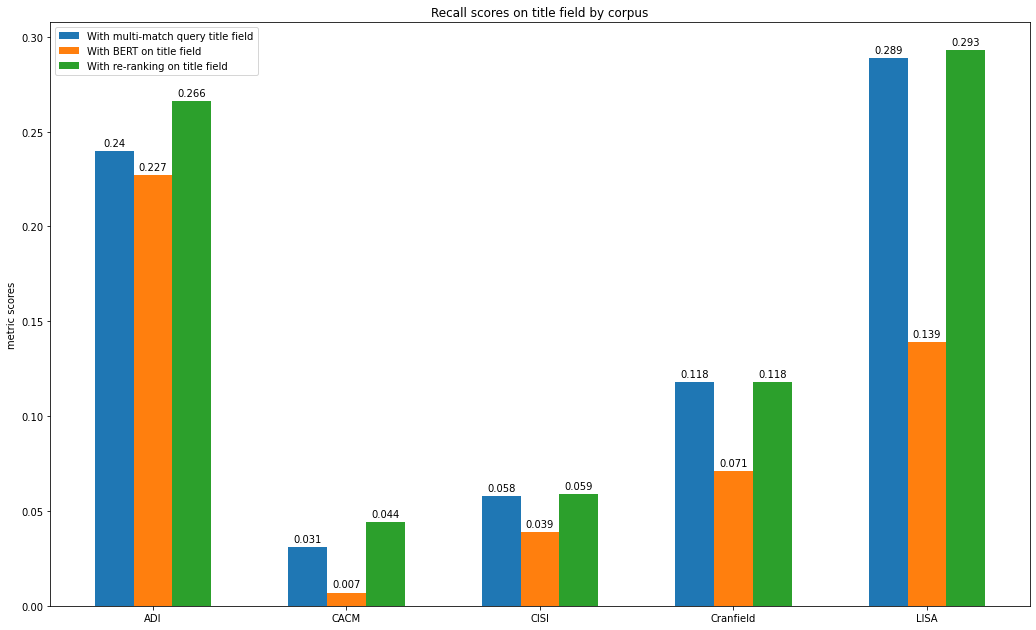

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_recall_title = []
match_metrics_recall_title.append(round(adi_res_match_recall_title['metric_score'], 3))
match_metrics_recall_title.append(round(cacm_res_match_recall_title['metric_score'], 3))
match_metrics_recall_title.append(round(cisi_res_match_recall_title['metric_score'], 3))
match_metrics_recall_title.append(round(cran_res_match_recall_title['metric_score'], 3))
match_metrics_recall_title.append(round(lisa_res_match_recall_title['metric_score'], 3))

bert_title_metrics_recall = []
bert_title_metrics_recall.append(round(adi_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cacm_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cisi_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cran_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(lisa_res_bert_title_recall['metric_score'], 3))

rerank_bert_title_metrics_recall = []
rerank_bert_title_metrics_recall.append(round(adi_res_rerank_title_recall['metric_score'], 3))
rerank_bert_title_metrics_recall.append(round(cacm_res_rerank_title_recall['metric_score'], 3))
rerank_bert_title_metrics_recall.append(round(cisi_res_rerank_title_recall['metric_score'], 3))
rerank_bert_title_metrics_recall.append(round(cran_res_rerank_title_recall['metric_score'], 3))
rerank_bert_title_metrics_recall.append(round(lisa_res_rerank_title_recall['metric_score'], 3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_recall_title , width, label='With multi-match query title field')
rects2 = ax.bar(x, bert_title_metrics_recall, width, label='With BERT on title field')
rects3 = ax.bar(x + width, rerank_bert_title_metrics_recall, width, label='With re-ranking on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Recall scores on title field by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(10)

plt.show()

**Recall on 'text' field**

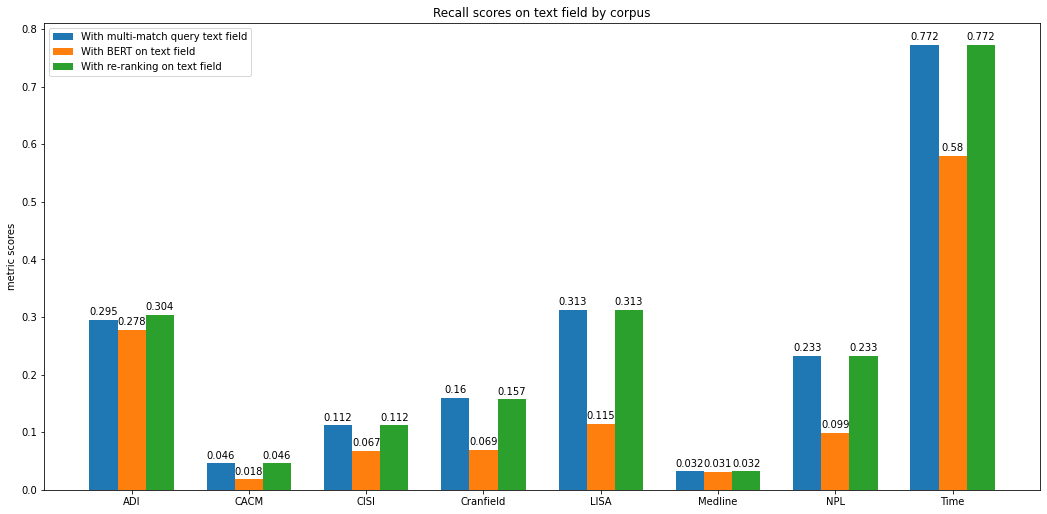

In [42]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_recall_text = []
match_metrics_recall_text.append(round(adi_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(cacm_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(cisi_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(cran_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(lisa_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(med_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(npl_res_match_recall_text['metric_score'], 3))
match_metrics_recall_text.append(round(time_res_match_recall_text['metric_score'], 3))

bert_text_metrics_recall = []
bert_text_metrics_recall.append(round(adi_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(cacm_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(cisi_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(cran_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(lisa_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(med_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(npl_res_bert_text_recall['metric_score'], 3))
bert_text_metrics_recall.append(round(time_res_bert_text_recall['metric_score'], 3))

rerank_bert_text_metrics_recall = []
rerank_bert_text_metrics_recall.append(round(adi_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(cacm_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(cisi_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(cran_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(lisa_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(med_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(npl_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(time_res_rerank_text_recall['metric_score'], 3))


labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL', 'Time']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_recall_text , width, label='With multi-match query text field')
rects2 = ax.bar(x, bert_text_metrics_recall, width, label='With BERT on text field')
rects3 = ax.bar(x + width, rerank_bert_text_metrics_recall, width, label='With re-ranking on text field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Recall scores on text field by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

**Recall on a complex re-ranking query**

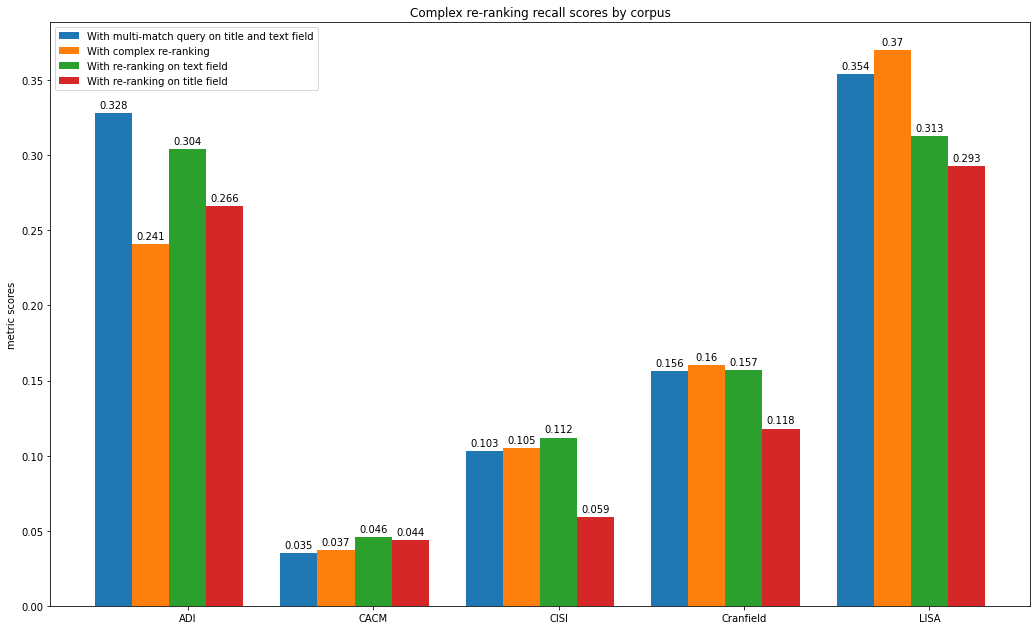

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_recall_text_title = []
match_metrics_recall_text_title.append(round(adi_res_match_recall_text_title['metric_score'], 3))
match_metrics_recall_text_title.append(round(cacm_res_match_recall_text_title['metric_score'], 3))
match_metrics_recall_text_title.append(round(cisi_res_match_recall_text_title['metric_score'], 3))
match_metrics_recall_text_title.append(round(cran_res_match_recall_text_title['metric_score'], 3))
match_metrics_recall_text_title.append(round(lisa_res_match_recall_text_title['metric_score'], 3))

complex_rerank_bert_metrics_recall = []
complex_rerank_bert_metrics_recall.append(round(adi_res_complex_rerank_recall['metric_score'], 3))
complex_rerank_bert_metrics_recall.append(round(cacm_res_complex_rerank_recall['metric_score'], 3))
complex_rerank_bert_metrics_recall.append(round(cisi_res_complex_rerank_recall['metric_score'], 3))
complex_rerank_bert_metrics_recall.append(round(cran_res_complex_rerank_recall['metric_score'], 3))
complex_rerank_bert_metrics_recall.append(round(lisa_res_complex_rerank_recall['metric_score'], 3))

rerank_bert_text_metrics_recall = []
rerank_bert_text_metrics_recall.append(round(adi_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(cacm_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(cisi_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(cran_res_rerank_text_recall['metric_score'], 3))
rerank_bert_text_metrics_recall.append(round(lisa_res_rerank_text_recall['metric_score'], 3))

rerank_bert_title_metrics_recall = []
rerank_bert_title_metrics_recall.append(round(adi_res_rerank_title_recall['metric_score'], 3))
rerank_bert_title_metrics_recall.append(round(cacm_res_rerank_title_recall['metric_score'], 3))
rerank_bert_title_metrics_recall.append(round(cisi_res_rerank_title_recall['metric_score'], 3))
rerank_bert_title_metrics_recall.append(round(cran_res_rerank_title_recall['metric_score'], 3))
rerank_bert_title_metrics_recall.append(round(lisa_res_rerank_title_recall['metric_score'], 3))


labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width, match_metrics_recall_text_title , width, label='With multi-match query on title and text field')
rects2 = ax.bar(x - width, complex_rerank_bert_metrics_recall , width, label='With complex re-ranking')
rects3 = ax.bar(x, rerank_bert_text_metrics_recall, width, label='With re-ranking on text field')
rects4 = ax.bar(x + width, rerank_bert_title_metrics_recall, width, label='With re-ranking on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Complex re-ranking recall scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(10)

plt.show()

### Precision

**Precision on 'title' field**

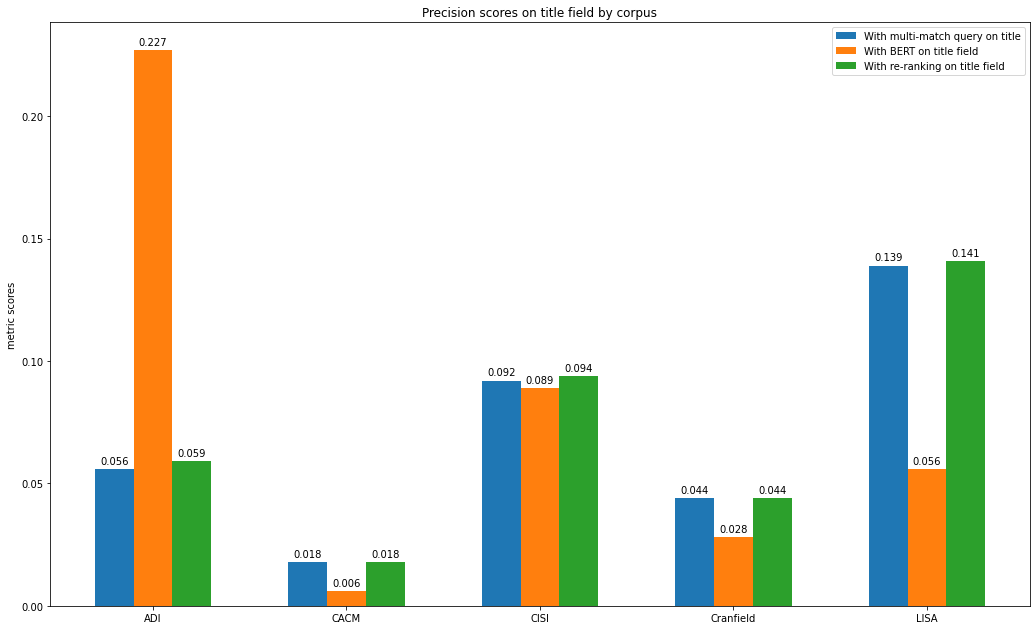

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_precision_title = []
match_metrics_precision_title.append(round(adi_res_match_precision_title['metric_score'], 3))
match_metrics_precision_title.append(round(cacm_res_match_precision_title['metric_score'], 3))
match_metrics_precision_title.append(round(cisi_res_match_precision_title['metric_score'], 3))
match_metrics_precision_title.append(round(cran_res_match_precision_title['metric_score'], 3))
match_metrics_precision_title.append(round(lisa_res_match_precision_title['metric_score'], 3))

bert_title_metrics_precision = []
bert_title_metrics_precision.append(round(adi_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cacm_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cisi_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cran_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(lisa_res_bert_title_precision['metric_score'], 3))

rerank_bert_title_metrics_precision = []
rerank_bert_title_metrics_precision.append(round(adi_res_rerank_title_precision['metric_score'], 3))
rerank_bert_title_metrics_precision.append(round(cacm_res_rerank_title_precision['metric_score'], 3))
rerank_bert_title_metrics_precision.append(round(cisi_res_rerank_title_precision['metric_score'], 3))
rerank_bert_title_metrics_precision.append(round(cran_res_rerank_title_precision['metric_score'], 3))
rerank_bert_title_metrics_precision.append(round(lisa_res_rerank_title_precision['metric_score'], 3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_precision_title , width, label='With multi-match query on title')
rects2 = ax.bar(x, bert_title_metrics_precision, width, label='With BERT on title field')
rects3 = ax.bar(x + width, rerank_bert_title_metrics_precision, width, label='With re-ranking on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Precision scores on title field by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(10)

plt.show()

**Precision on 'text' field**

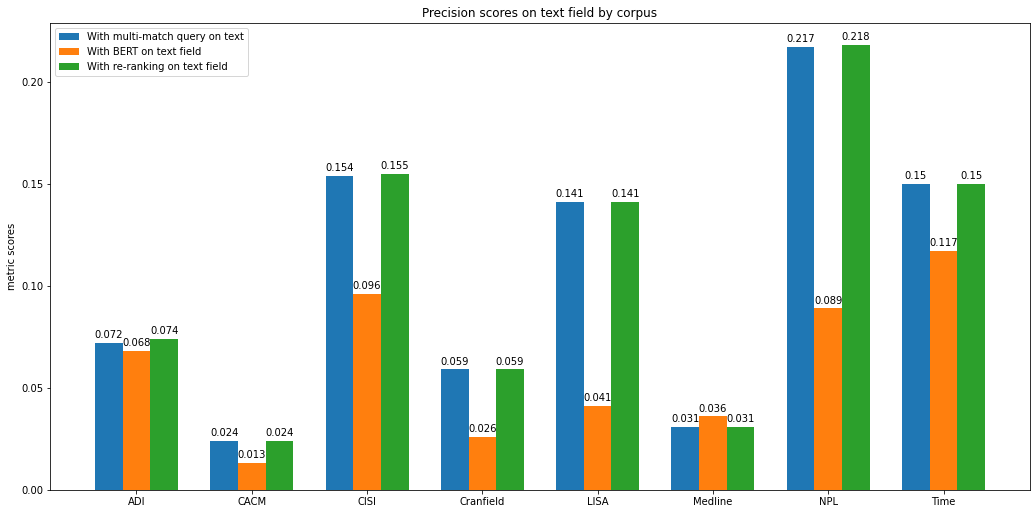

In [45]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_precision_text = []
match_metrics_precision_text.append(round(adi_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(cacm_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(cisi_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(cran_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(lisa_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(med_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(npl_res_match_precision_text['metric_score'], 3))
match_metrics_precision_text.append(round(time_res_match_precision_text['metric_score'], 3))

bert_text_metrics_precision = []
bert_text_metrics_precision.append(round(adi_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(cacm_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(cisi_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(cran_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(lisa_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(med_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(npl_res_bert_text_precision['metric_score'], 3))
bert_text_metrics_precision.append(round(time_res_bert_text_precision['metric_score'], 3))

rerank_bert_text_metrics_precision = []
rerank_bert_text_metrics_precision.append(round(adi_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(cacm_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(cisi_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(cran_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(lisa_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(med_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(npl_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(time_res_rerank_text_precision['metric_score'], 3))


labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL', 'Time']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_precision_text , width, label='With multi-match query on text')
rects2 = ax.bar(x, bert_text_metrics_precision, width, label='With BERT on text field')
rects3 = ax.bar(x + width, rerank_bert_text_metrics_precision, width, label='With re-ranking on text field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Precision scores on text field by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

**Precision on a complex re-ranking query**

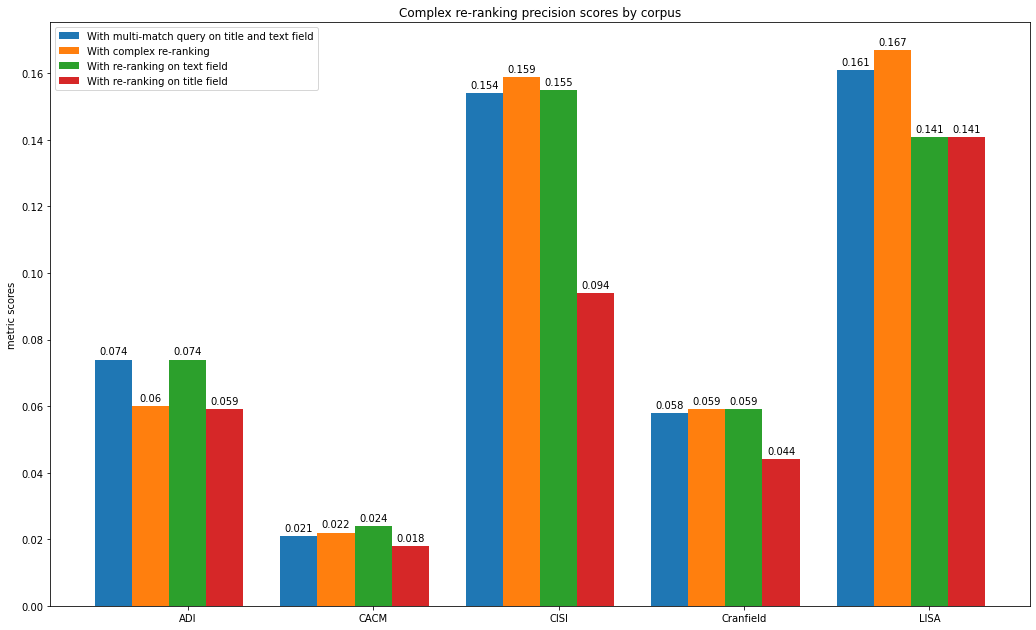

In [46]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_precision_text_title = []
match_metrics_precision_text_title.append(round(adi_res_match_precision_text_title['metric_score'], 3))
match_metrics_precision_text_title.append(round(cacm_res_match_precision_text_title['metric_score'], 3))
match_metrics_precision_text_title.append(round(cisi_res_match_precision_text_title['metric_score'], 3))
match_metrics_precision_text_title.append(round(cran_res_match_precision_text_title['metric_score'], 3))
match_metrics_precision_text_title.append(round(lisa_res_match_precision_text_title['metric_score'], 3))

complex_rerank_bert_metrics_precision = []
complex_rerank_bert_metrics_precision.append(round(adi_res_complex_rerank_precision['metric_score'], 3))
complex_rerank_bert_metrics_precision.append(round(cacm_res_complex_rerank_precision['metric_score'], 3))
complex_rerank_bert_metrics_precision.append(round(cisi_res_complex_rerank_precision['metric_score'], 3))
complex_rerank_bert_metrics_precision.append(round(cran_res_complex_rerank_precision['metric_score'], 3))
complex_rerank_bert_metrics_precision.append(round(lisa_res_complex_rerank_precision['metric_score'], 3))

rerank_bert_text_metrics_precision = []
rerank_bert_text_metrics_precision.append(round(adi_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(cacm_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(cisi_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(cran_res_rerank_text_precision['metric_score'], 3))
rerank_bert_text_metrics_precision.append(round(lisa_res_rerank_text_precision['metric_score'], 3))

rerank_bert_title_metrics_precision = []
rerank_bert_title_metrics_precision.append(round(adi_res_rerank_title_precision['metric_score'], 3))
rerank_bert_title_metrics_precision.append(round(cacm_res_rerank_title_precision['metric_score'], 3))
rerank_bert_title_metrics_precision.append(round(cisi_res_rerank_title_precision['metric_score'], 3))
rerank_bert_title_metrics_precision.append(round(cran_res_rerank_title_precision['metric_score'], 3))
rerank_bert_title_metrics_precision.append(round(lisa_res_rerank_title_precision['metric_score'], 3))


labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width, match_metrics_precision_text_title , width, label='With multi-match query on title and text field')
rects2 = ax.bar(x - width, complex_rerank_bert_metrics_precision , width, label='With complex re-ranking')
rects3 = ax.bar(x, rerank_bert_text_metrics_precision, width, label='With re-ranking on text field')
rects4 = ax.bar(x + width, rerank_bert_title_metrics_precision, width, label='With re-ranking on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Complex re-ranking precision scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(10)

plt.show()

### F-Score

**F-Score on 'title' field**

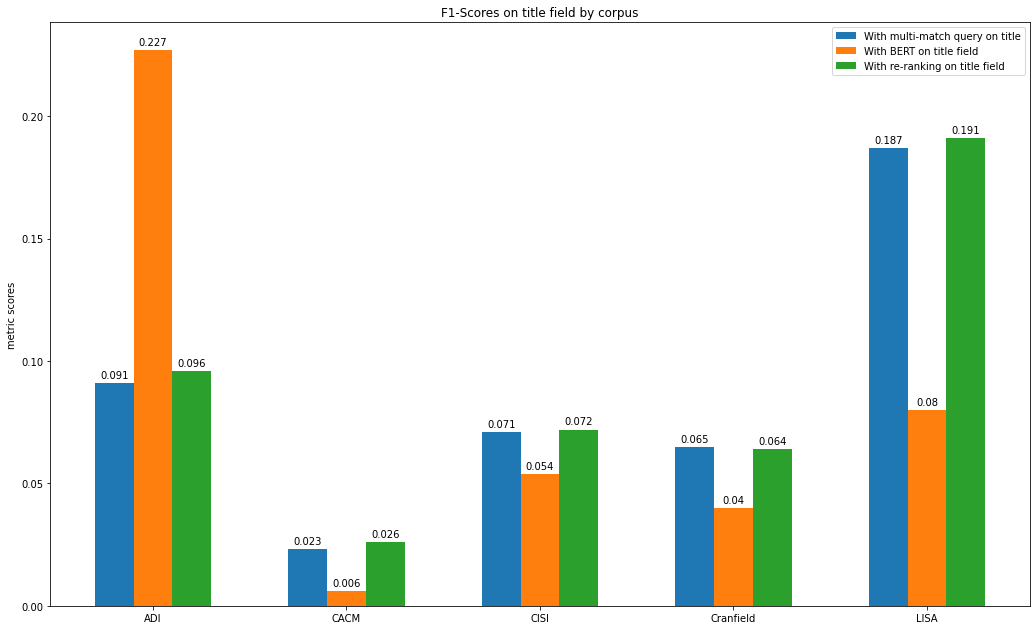

In [47]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def f_score(recall,precision):
  if recall or precision != 0:
    fscore = (2*(recall*precision)/(recall+precision))
    return fscore

match_metrics_fscore_title = []
match_metrics_fscore_title.append(round(f_score(adi_res_match_recall_title['metric_score'], adi_res_match_precision_title['metric_score']),3))
match_metrics_fscore_title.append(round(f_score(cacm_res_match_recall_title['metric_score'], cacm_res_match_precision_title['metric_score']),3))
match_metrics_fscore_title.append(round(f_score(cisi_res_match_recall_title['metric_score'], cisi_res_match_precision_title['metric_score']),3))
match_metrics_fscore_title.append(round(f_score(cran_res_match_recall_title['metric_score'], cran_res_match_precision_title['metric_score']),3))
match_metrics_fscore_title.append(round(f_score(lisa_res_match_recall_title['metric_score'], lisa_res_match_precision_title['metric_score']),3))

bert_title_metrics_fscore = []
bert_title_metrics_fscore.append(round(f_score(adi_res_bert_title_recall['metric_score'], adi_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cacm_res_bert_title_recall['metric_score'], cacm_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cisi_res_bert_title_recall['metric_score'], cisi_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cran_res_bert_title_recall['metric_score'], cran_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(lisa_res_bert_title_recall['metric_score'], lisa_res_bert_title_precision['metric_score']),3))

rerank_bert_title_metrics_fscore = []
rerank_bert_title_metrics_fscore.append(round(f_score(adi_res_rerank_title_recall['metric_score'], adi_res_rerank_title_precision['metric_score']),3))
rerank_bert_title_metrics_fscore.append(round(f_score(cacm_res_rerank_title_recall['metric_score'], cacm_res_rerank_title_precision['metric_score']),3))
rerank_bert_title_metrics_fscore.append(round(f_score(cisi_res_rerank_title_recall['metric_score'], cisi_res_rerank_title_precision['metric_score']),3))
rerank_bert_title_metrics_fscore.append(round(f_score(cran_res_rerank_title_recall['metric_score'], cran_res_rerank_title_precision['metric_score']),3))
rerank_bert_title_metrics_fscore.append(round(f_score(lisa_res_rerank_title_recall['metric_score'], lisa_res_rerank_title_precision['metric_score']),3))


labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_fscore_title , width, label='With multi-match query on title')
rects2 = ax.bar(x , bert_title_metrics_fscore, width, label='With BERT on title field')
rects3 = ax.bar(x + width, rerank_bert_title_metrics_fscore, width, label='With re-ranking on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('F1-Scores on title field by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(10)

plt.show()

**F-Score on 'text' field**

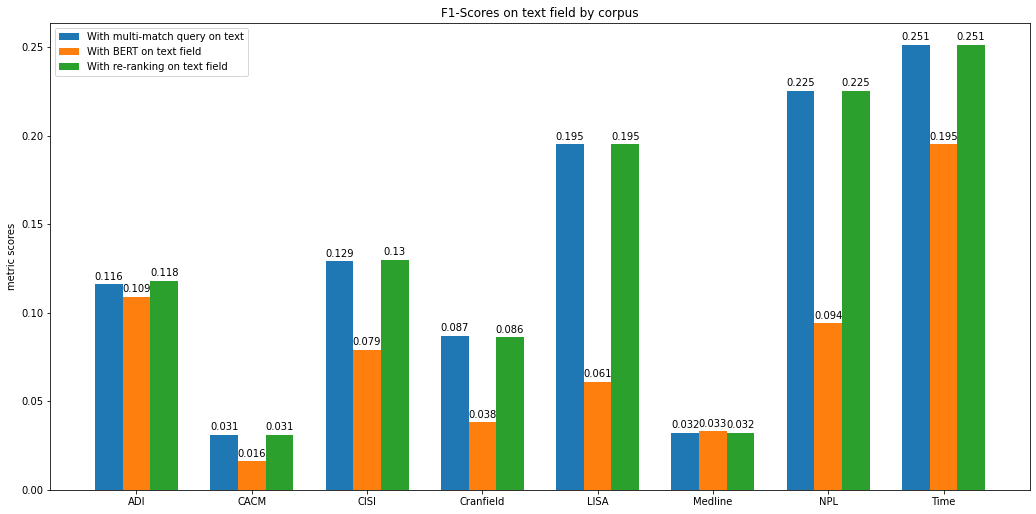

In [48]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def f_score(recall,precision):
  if recall or precision != 0:
    fscore = (2*(recall*precision)/(recall+precision))
    return fscore

match_metrics_fscore_text = []
match_metrics_fscore_text.append(round(f_score(adi_res_match_recall_text['metric_score'], adi_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(cacm_res_match_recall_text['metric_score'], cacm_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(cisi_res_match_recall_text['metric_score'], cisi_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(cran_res_match_recall_text['metric_score'], cran_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(lisa_res_match_recall_text['metric_score'], lisa_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(med_res_match_recall_text['metric_score'], med_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(npl_res_match_recall_text['metric_score'], npl_res_match_precision_text['metric_score']),3))
match_metrics_fscore_text.append(round(f_score(time_res_match_recall_text['metric_score'], time_res_match_precision_text['metric_score']),3))

bert_text_metrics_fscore = []
bert_text_metrics_fscore.append(round(f_score(adi_res_bert_text_recall['metric_score'], adi_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(cacm_res_bert_text_recall['metric_score'], cacm_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(cisi_res_bert_text_recall['metric_score'], cisi_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(cran_res_bert_text_recall['metric_score'], cran_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(lisa_res_bert_text_recall['metric_score'], lisa_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(med_res_bert_text_recall['metric_score'], med_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(npl_res_bert_text_recall['metric_score'], npl_res_bert_text_precision['metric_score']),3))
bert_text_metrics_fscore.append(round(f_score(time_res_bert_text_recall['metric_score'], time_res_bert_text_precision['metric_score']),3))

rerank_bert_text_metrics_fscore = []
rerank_bert_text_metrics_fscore.append(round(f_score(adi_res_rerank_text_recall['metric_score'], adi_res_rerank_text_precision['metric_score']),3))
rerank_bert_text_metrics_fscore.append(round(f_score(cacm_res_rerank_text_recall['metric_score'], cacm_res_rerank_text_precision['metric_score']),3))
rerank_bert_text_metrics_fscore.append(round(f_score(cisi_res_rerank_text_recall['metric_score'], cisi_res_rerank_text_precision['metric_score']),3))
rerank_bert_text_metrics_fscore.append(round(f_score(cran_res_rerank_text_recall['metric_score'], cran_res_rerank_text_precision['metric_score']),3))
rerank_bert_text_metrics_fscore.append(round(f_score(lisa_res_rerank_text_recall['metric_score'], lisa_res_rerank_text_precision['metric_score']),3))
rerank_bert_text_metrics_fscore.append(round(f_score(med_res_rerank_text_recall['metric_score'], med_res_rerank_text_precision['metric_score']),3))
rerank_bert_text_metrics_fscore.append(round(f_score(npl_res_rerank_text_recall['metric_score'], npl_res_rerank_text_precision['metric_score']),3))
rerank_bert_text_metrics_fscore.append(round(f_score(time_res_rerank_text_recall['metric_score'], time_res_rerank_text_precision['metric_score']),3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA', 'Medline', 'NPL', 'Time']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_fscore_text , width, label='With multi-match query on text')
rects2 = ax.bar(x , bert_text_metrics_fscore, width, label='With BERT on text field')
rects3 = ax.bar(x + width,rerank_bert_text_metrics_fscore, width, label='With re-ranking on text field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('F1-Scores on text field by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

**F-score on a complex re-ranking query**

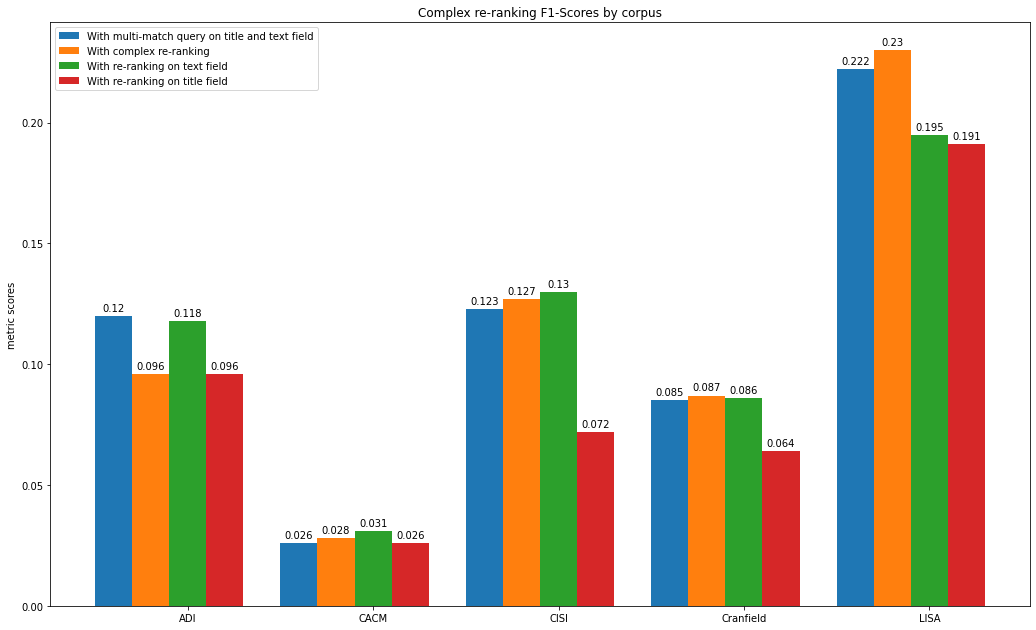

In [49]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def f_score(recall,precision):
  if recall or precision != 0:
    fscore = (2*(recall*precision)/(recall+precision))
    return fscore

match_metrics_fscore_text_title = []
match_metrics_fscore_text_title.append((round(f_score(adi_res_match_recall_text_title['metric_score'], adi_res_match_precision_text_title['metric_score']),3)))
match_metrics_fscore_text_title.append((round(f_score(cacm_res_match_recall_text_title['metric_score'], cacm_res_match_precision_text_title['metric_score']),3)))
match_metrics_fscore_text_title.append((round(f_score(cisi_res_match_recall_text_title['metric_score'], cisi_res_match_precision_text_title['metric_score']),3)))
match_metrics_fscore_text_title.append((round(f_score(cran_res_match_recall_text_title['metric_score'], cran_res_match_precision_text_title['metric_score']),3)))
match_metrics_fscore_text_title.append((round(f_score(lisa_res_match_recall_text_title['metric_score'], lisa_res_match_precision_text_title['metric_score']),3)))

complex_rerank_bert_metrics_fscore = []
complex_rerank_bert_metrics_fscore.append((round(f_score(adi_res_complex_rerank_recall['metric_score'], adi_res_complex_rerank_precision['metric_score']),3)))
complex_rerank_bert_metrics_fscore.append((round(f_score(cacm_res_complex_rerank_recall['metric_score'], cacm_res_complex_rerank_precision['metric_score']),3)))
complex_rerank_bert_metrics_fscore.append((round(f_score(cisi_res_complex_rerank_recall['metric_score'], cisi_res_complex_rerank_precision['metric_score']),3)))
complex_rerank_bert_metrics_fscore.append((round(f_score(cran_res_complex_rerank_recall['metric_score'], cran_res_complex_rerank_precision['metric_score']),3)))
complex_rerank_bert_metrics_fscore.append((round(f_score(lisa_res_complex_rerank_recall['metric_score'], lisa_res_complex_rerank_precision['metric_score']),3)))

rerank_bert_text_metrics_fscore = []
rerank_bert_text_metrics_fscore.append((round(f_score(adi_res_rerank_text_recall['metric_score'], adi_res_rerank_text_precision['metric_score']),3)))
rerank_bert_text_metrics_fscore.append((round(f_score(cacm_res_rerank_text_recall['metric_score'], cacm_res_rerank_text_precision['metric_score']),3)))
rerank_bert_text_metrics_fscore.append((round(f_score(cisi_res_rerank_text_recall['metric_score'], cisi_res_rerank_text_precision['metric_score']),3)))
rerank_bert_text_metrics_fscore.append((round(f_score(cran_res_rerank_text_recall['metric_score'], cran_res_rerank_text_precision['metric_score']),3)))
rerank_bert_text_metrics_fscore.append((round(f_score(lisa_res_rerank_text_recall['metric_score'], lisa_res_rerank_text_precision['metric_score']),3)))

rerank_bert_title_metrics_fscore = []
rerank_bert_title_metrics_fscore.append((round(f_score(adi_res_rerank_title_recall['metric_score'], adi_res_rerank_title_precision['metric_score']),3)))
rerank_bert_title_metrics_fscore.append((round(f_score(cacm_res_rerank_title_recall['metric_score'], cacm_res_rerank_title_precision['metric_score']),3)))
rerank_bert_title_metrics_fscore.append((round(f_score(cisi_res_rerank_title_recall['metric_score'], cisi_res_rerank_title_precision['metric_score']),3)))
rerank_bert_title_metrics_fscore.append((round(f_score(cran_res_rerank_title_recall['metric_score'], cran_res_rerank_title_precision['metric_score']),3)))
rerank_bert_title_metrics_fscore.append((round(f_score(lisa_res_rerank_title_recall['metric_score'], lisa_res_rerank_title_precision['metric_score']),3)))


labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA']

x = np.arange(len(labels))*2.5  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width, match_metrics_fscore_text_title , width, label='With multi-match query on title and text field')
rects2 = ax.bar(x - width, complex_rerank_bert_metrics_fscore , width, label='With complex re-ranking')
rects3 = ax.bar(x, rerank_bert_text_metrics_fscore, width, label='With re-ranking on text field')
rects4 = ax.bar(x + width, rerank_bert_title_metrics_fscore, width, label='With re-ranking on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Complex re-ranking F1-Scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(10)

plt.show()

# Read More
Details on this experiment can be found on our [website](https://pragmalingu.de/docs/experiments/experiment2).